# 2 - Features engeniering Jeux Ps5 - Playstation Store

## Objectifs de ce notebook

Dans ce notebook, nous allons créer les features de baisse de prix à prédire.

- Classification binaire 50% réduction avant 1 an

Nous allons également créer des features supplémentaire pour aider le pouvoir de prédiction:
- Travail sur les publishers
- Travail sur la création de seuil et de colonnes catégorielle pertinentes

## Données utilisées

Utilisation du fichier csv nettoyé extrait du fichier JSON raw construit depuis les APIs

**data/processed/games_data.csv**.

## Import librairies

In [530]:
import sys
from pathlib import Path
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

from sklearn.preprocessing import MultiLabelBinarizer

# Ajouter le dossier parent src au path
sys.path.append(os.path.abspath('..'))

%matplotlib inline


## CONSTANTES

In [531]:
EXTRACT_DATE = datetime(2025, 11, 1, 17, 2, 28)

PRICE_SEGMENTS = [
    {
        "label": "0 - 7.99",
        "value_min": 0,
        "value_max": 7.99,
    },
    {
        "label": "8 - 14.99",
        "value_min": 8,
        "value_max": 14.99,
    },
    {
        "label": "15 - 24.99",
        "value_min": 15,
        "value_max": 24.99,
    },
    {
        "label": "25 - 39.99",
        "value_min": 25,
        "value_max": 39.99,
    },
    {
        "label": "40+",
        "value_min": 40,
        "value_max": 150,
    },
]

WAIT_DISCOUNT_SEGMENTS = [
    {
        "label": "0-3_mois",
        "value_min": 0,
        "value_max": 90,
    },
    {
        "label": "3-6_mois",
        "value_min": 91,
        "value_max": 180,
    },
    {
        "label": "6-12_mois",
        "value_min": 181,
        "value_max": 365,
    },
    {
        "label": "1-2_ans",
        "value_min": 366,
        "value_max": 730,
    },
    {
        "label": "jamais_ou_plus",
        "value_min": 731,
        "value_max": float('inf'),
    },
]

PROMOS = [10,25,33,50,75]

discount_helper = [{"days_from_release":30,"percent_discount":5},
                   {"days_from_release":60,"percent_discount":10}]


## Chargement des données

In [532]:
# Fichier stocké temporairement sur un de mes S3
# url = "https://d3aok2axxchxf9.cloudfront.net/ia/games_data.csv"

url = os.path.join(Path.cwd().parent, "data/processed/games_data.csv")

# Charger les données CSV, Les colonnes Boolean sont au format Int64 (0,1,NaN)
df = pd.read_csv(url,dtype={
    'trophies_count': 'Int64',
    'local_multiplayer_max_players': 'Int64',
    'online_multiplayer_max_players': 'Int64',
    'difficulty': 'Int64',
    'download_size': 'Int64',
    'hours_main_story': 'Int64',
    'hours_completionist': 'Int64',
    'metacritic_critic_score': 'Int64',
    'metacritic_critic_userscore': 'Int64',
    'pegi_rating': 'Int64',
})


## Vérification des données chargées

In [533]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [534]:
column_summary(df)

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
                     game_name  object            5382           0           5382
                      id_store  object            5382           0           5382
                short_url_name  object            5382           0           5382
                     publisher  object            5382           0           1061
                     developer  object            3920        1462           2709
                  release_date  object            5382           0           1347
         pssstore_stars_rating float64            5382           0            352
   pssstore_stars_rating_count   int64            5382           0           1583
       metacritic_critic_score   Int64            1268        4114             67
   metacritic_critic_userscore   Int64            1268        4114             10
                        genres  object            5360          22  

In [535]:
df.head()

,game_name,id_store,short_url_name,publisher,developer,release_date,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,...,hours_main_story,hours_completionist,pegi_rating,esrb_rating,rating_descriptions,voice_languages,subtitle_languages,base_price,lowest_price,price_history
0,"#Halloween, Super Puzzles Dream",EP8311-PPSA19174_00-0421646910657705,game-halloween-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-10-30,1.57,14,<NA>,<NA>,...,<NA>,<NA>,7,Everyone,Fear/Horror,NaN,NaN,4.99,1.49,"[{""x"": ""2023-11-02"", ""y"": 4.99}, {""x"": ""2023-1..."
1,#SinucaAttack,EP2005-PPSA06055_00-SINUCA0000000000,game-sinucaattack-ps5,eastasiasoft,NaN,2022-05-19,3.26,72,<NA>,<NA>,...,0,0,3,Everyone,Fantasy Violence,NaN,NaN,4.99,1.49,"[{""x"": ""2022-05-21"", ""y"": 4.99}, {""x"": ""2022-1..."
2,"#Wish travel, super puzzle dreams",EP8311-PPSA16513_00-0233078860249892,game-wish-travel-super-puzzle-dreams-ps5,e-llusiontertainment,NaN,2023-05-31,1.55,11,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-06-19"", ""y"": 4.99}, {""x"": ""2023-0..."
3,"#WomenUp, Super Puzzles Dream",EP8311-PPSA13840_00-0277389480637871,game-womenup-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-01-26,1.44,18,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-05-21"", ""y"": 4.99}, {""x"": ""2023-0..."
4,"#Xmas, Super Puzzles Dream",EP8311-PPSA12662_00-0212989199890961,game-xmas-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2022-12-22,1.17,23,<NA>,<NA>,...,<NA>,<NA>,3,Everyone,NaN,NaN,NaN,4.99,1.49,"[{""x"": ""2023-01-23"", ""y"": 4.99}, {""x"": ""2023-0..."


## Methodes utils

In [536]:
def print_nan_stats(df:pd.DataFrame, column:str):
    nan_count = df[column].isna().sum()
    non_nan_count = df[column].notna().sum()
    total = len(df)
    
    print(f"    NaN: {nan_count} ({nan_count/total*100:.1f}%)")
    print(f"    Non-NaN: {non_nan_count} ({non_nan_count/total*100:.1f}%)")

In [537]:
def draw_binary_circular_plots(data: list, name: str, axe: plt.Axes):
    colors = sns.color_palette("crest")
    values = [item["value"] for item in data]
    labels = [item["label"] for item in data]

    wedges, texts, autotexts = axe.pie(
        values,
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
        startangle=90,
        shadow=False,
    )

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    axe.set_title(f"{name}", fontweight="bold", pad=20)

In [538]:
def layout_plots(n_cols: int):
    # Calculer le nombre de lignes nécessaires
    actual_rows = (n_cols + 2) // 3  # 3 colonnes par ligne

    # Limiter à 3 colonnes maximum
    actual_cols = min(n_cols, 3)

    # Créer la figure avec plus d'espace vertical
    fig, axes = plt.subplots(
        actual_rows, 
        actual_cols, 
        figsize=(14, 5 * actual_rows),  # Hauteur dynamique selon le nombre de lignes
        gridspec_kw={'hspace': 0.5, 'wspace': 0.3}  # ← Espace entre les lignes/colonnes
    )

    # Normaliser axes pour toujours retourner un tableau 1D itérable
    if n_cols == 1:
        axes = [axes]
    elif actual_rows == 1 and actual_cols == 1:
        axes = [axes]
    elif actual_rows == 1:
        axes = list(axes)
    else:
        axes = list(axes.flatten())

    return fig, axes

In [539]:
def generate_multi_str_col_top_proportion_data(
    df: pd.DataFrame, col_name: str, top_count: int
):

    # Séparer et exploser
    col_exploded = df[col_name].str.split(",").explode()
    col_exploded = col_exploded.str.strip()
    col_value_count = col_exploded.value_counts()

    # Garder le top 6 et regrouper le reste dans "Autres"
    top_val = col_value_count.head(top_count)
    autres = col_value_count.iloc[top_count:].sum()

    # Créer les données finales
    if autres > 0:
        final_counts = pd.concat([top_val, pd.Series({"Autres": autres})])
    else:
        final_counts = top_val

    result = []
    for label, value in final_counts.items():
        result.append(
            {
                "label": label,
                "value": value,
            }
        )

    return result

In [540]:
def generate_binary_cols_proportion_data(df: pd.DataFrame, column_name: str):
    binary_cols = [col for col in df.columns if col == column_name]

    if len(binary_cols) == 0:
        return None

    result = [
        {
            "label": "True",
            "value": (
                (df[binary_cols[0]] == 1).sum() / len(df) * 100 if len(df) > 0 else 0
            ),
        },
        {
            "label": "False",
            "value": (
                (df[binary_cols[0]] == 0).sum() / len(df) * 100 if len(df) > 0 else 0
            ),
        },
    ]

    return result

In [541]:
df_featured = df.copy()

## Transformation des dates en valeures numérique

In [542]:
def transform_dates(df:pd.DataFrame,today:datetime):
    df['release_date_dt'] = pd.to_datetime(df['release_date'], errors='coerce')
    df['release_year'] = df['release_date_dt'].dt.year
    df['release_month'] = df['release_date_dt'].dt.month
    df['days_since_release'] = (today - df['release_date_dt']).dt.days
    
    df.drop(['release_date_dt'], axis='columns', inplace=True)
    return df

In [543]:
df_featured = transform_dates(df_featured,EXTRACT_DATE)

## Création des features délais avant promos depuis la sortie (à prédire)

In [544]:
df_days_to_discount = df_featured.copy()

In [545]:
# Convertir la colonne price_history de JSON vers list
df_days_to_discount['price_history'] = df_days_to_discount['price_history'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x
)

In [546]:
def days_until_first_discount(
    sales_history, base_price, release_date, discount_threshold=0
):
    if release_date is None:
        return None

    if len(sales_history) == 0:
        return None

    if not isinstance(base_price, (int, float)):
        return None

    # Convertir release_date en datetime si c'est une string
    if isinstance(release_date, str):
        release_date = datetime.strptime(release_date, "%Y-%m-%d")

    # Calculer le prix cible selon le seuil de réduction
    target_price = base_price * (1 - discount_threshold / 100)

    # Parcourir l'historique pour trouver la première baisse atteignant le seuil
    for entry in sales_history:
        price = entry["y"]
        date_str = entry["x"]
        date = datetime.strptime(date_str, "%Y-%m-%d")

        # Ignorer les prix négatifs
        if price < 0.1:
            continue

        # Vérifier si la réduction atteint le seuil et après la date de sortie
        if price <= target_price and date >= release_date:
            days_diff = (date - release_date).days
            return days_diff

    # Aucune baisse au seuil voulu trouvée
    return None

In [547]:
def generate_day_to_discount_df_data(df:pd.DataFrame):
    for promo in PROMOS:
        col_name = f'days_to_{promo}_percent_discount'
        df[col_name] = df.apply(
            lambda row: days_until_first_discount(
                row['price_history'], 
                row['base_price'], 
                row['release_date'], 
                promo
            ),
            axis=1
        )
    return df

In [548]:
df_days_to_discount = generate_day_to_discount_df_data(df_days_to_discount)

In [549]:
for promo in PROMOS:
    col_name = f'days_to_{promo}_percent_discount'
    print('\n')
    print(df_days_to_discount[col_name].describe())



count    4778.000000
mean      111.046463
std       114.792521
min         0.000000
25%        48.000000
50%        76.000000
75%       128.000000
max      1292.000000
Name: days_to_10_percent_discount, dtype: float64


count    4509.000000
mean      139.444666
std       130.566226
min         0.000000
25%        57.000000
50%        98.000000
75%       175.000000
max      1292.000000
Name: days_to_25_percent_discount, dtype: float64


count    3714.000000
mean      205.792138
std       159.093618
min         0.000000
25%        97.000000
50%       168.000000
75%       268.000000
max      1533.000000
Name: days_to_33_percent_discount, dtype: float64


count    3091.000000
mean      290.918149
std       207.714124
min         0.000000
25%       142.000000
50%       247.000000
75%       380.000000
max      1574.000000
Name: days_to_50_percent_discount, dtype: float64


count    1025.000000
mean      519.724878
std       324.242354
min         1.000000
25%       266.000000
50%       476

In [550]:
def day_to_promo_summary(df:pd.DataFrame):
    summary_data = []
    for promo in PROMOS:
        col = f'days_to_{promo}_percent_discount'
        summary_data.append({
            'Réduction': f'-{promo}%',
            'Jeux concernés': df[col].notna().sum(),
            'Pourcentage': f"{(df[col].notna().sum() / len(df)) * 100:.1f}%",
            'Médiane (jours)': df[col].median(),
            'Moyenne (jours)': df[col].mean(),
            'Min (jours)': df[col].min(),
            'Max (jours)': df[col].max()
        })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + "="*80)
    print("RÉSUMÉ DES PROMOTIONS")
    print("="*80)
    print(summary_df.to_string(index=False))

In [551]:
day_to_promo_summary(df_days_to_discount)


RÉSUMÉ DES PROMOTIONS
Réduction  Jeux concernés Pourcentage  Médiane (jours)  Moyenne (jours)  Min (jours)  Max (jours)
     -10%            4778       88.8%             76.0       111.046463          0.0       1292.0
     -25%            4509       83.8%             98.0       139.444666          0.0       1292.0
     -33%            3714       69.0%            168.0       205.792138          0.0       1533.0
     -50%            3091       57.4%            247.0       290.918149          0.0       1574.0
     -75%            1025       19.0%            476.0       519.724878          1.0       1806.0


In [552]:
def create_wait_to_discount_category(df: pd.DataFrame, target_promo: int):
    df_copy = df.copy()
    target_col = f'days_to_{target_promo}_percent_discount'
    col_name = f'days_to_{target_promo}_percent_discount_category'
    
    # Extraire les bins et labels depuis WAIT_DISCOUNT_SEGMENTS
    bins = [segment['value_min'] for segment in WAIT_DISCOUNT_SEGMENTS] + [float('inf')]
    labels = [segment['label'] for segment in WAIT_DISCOUNT_SEGMENTS]
    
    # Créer les catégories
    df_copy[col_name] = pd.cut(
        df_copy[target_col],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    )
    
    df_copy[col_name] = df_copy[col_name].astype(str)
    
    # Gérer les NaN pour days_since_release
    # le jeu n'a JAMAIS atteint une baisse de {target_promo}%
    mask_nan = df_copy[target_col].isna()
    
    # jeux récents (<2 ans) qui n'ont PAS ENCORE atteint {target_promo}%
    mask_recent = mask_nan & (df_copy['days_since_release'] < 730)
    df_copy.loc[mask_recent, col_name] = 'moins_de_2_ans_sans_baisse'
    
    # jeux anciens (>=2 ans) qui n'ont JAMAIS atteint {target_promo}%
    mask_old = mask_nan & (df_copy['days_since_release'] >= 730)
    df_copy.loc[mask_old, col_name] = 'jamais_ou_plus'
    
    # NaN dans days_since_release = jeu par encore sortis ou erreur de date de sortie
    mask_unknown = mask_nan & df_copy['days_since_release'].isna()
    df_copy.loc[mask_unknown, col_name] = 'moins_de_2_ans_sans_baisse'
    
    return df_copy

In [553]:
# Pour chaque seuil de promo on crée la colonne de catégorie associée
for promo in PROMOS:
    df_days_to_discount = create_wait_to_discount_category(df_days_to_discount, promo)

In [554]:
def verification_to_discount_categorie(df:pd.DataFrame):
    for promo in PROMOS:
        col_name = f'days_to_{promo}_percent_discount_category'
        print('\n')
        print(df_days_to_discount[col_name].value_counts())

In [555]:
verification_to_discount_categorie(df_days_to_discount)



days_to_10_percent_discount_category
0-3_mois                      2898
3-6_mois                      1161
moins_de_2_ans_sans_baisse     559
6-12_mois                      533
1-2_ans                        160
jamais_ou_plus                  71
Name: count, dtype: int64


days_to_25_percent_discount_category
0-3_mois                      2090
3-6_mois                      1349
moins_de_2_ans_sans_baisse     813
6-12_mois                      799
1-2_ans                        237
jamais_ou_plus                  94
Name: count, dtype: int64


days_to_33_percent_discount_category
moins_de_2_ans_sans_baisse    1367
6-12_mois                     1244
3-6_mois                      1145
0-3_mois                       854
1-2_ans                        414
jamais_ou_plus                 358
Name: count, dtype: int64


days_to_50_percent_discount_category
moins_de_2_ans_sans_baisse    1847
6-12_mois                     1216
1-2_ans                        702
3-6_mois                       

In [556]:
def show_distribution_classe_wait_discount(df:pd.DataFrame):
    # Créer la figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Ordre logique des catégories
    category_order = ['0-3_mois', '3-6_mois', '6-12_mois', '1-2_ans', 
                    'moins_de_2_ans_sans_baisse', 'jamais_ou_plus']

    # Couleurs cohérentes
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#95a5a6', "#315c87"]
    color_map = {cat: colors[i] for i, cat in enumerate(category_order)}

    # Créer les graphiques
    for idx, promo in enumerate(PROMOS):
        ax = axes[idx]
        col_name = f'days_to_{promo}_percent_discount_category'
        
        # Récupérer les valeurs
        value_counts = df[col_name].value_counts()
        
        # Réorganiser selon l'ordre logique
        ordered_counts = value_counts.reindex(category_order, fill_value=0)
        total = ordered_counts.sum()
        
        # Barplot
        bars = ax.bar(range(len(ordered_counts)), ordered_counts.values, 
                    color=[color_map[cat] for cat in ordered_counts.index],
                    alpha=0.7, edgecolor='black')
        
        ax.set_xticks(range(len(ordered_counts)))
        ax.set_xticklabels(ordered_counts.index, rotation=45, ha='right', fontsize=9)
        ax.set_ylabel('Nombre de jeux', fontsize=11)
        ax.set_title(f'Délai pour {promo}% de réduction', fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
    
        # Ajouter les pourcentages
        for bar, val in zip(bars, ordered_counts.values):
            if val > 0:
                pct = val / total * 100
                ax.text(bar.get_x() + bar.get_width()/2, val + total*0.01,
                        f'{val}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=8)

    # Supprimer le 6ème subplot vide et ajouter une légende
    fig.delaxes(axes[5])
    axes[5] = fig.add_subplot(2, 3, 6)
    axes[5].axis('off')

    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=color_map[cat], 
                                    alpha=0.7, edgecolor='black', label=cat)
                    for cat in category_order]
    axes[5].legend(handles=legend_elements, loc='center', fontsize=11, 
                title='Catégories temporelles', title_fontsize=12)

    plt.suptitle('Distribution des délais avant réduction par pourcentage', 
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()

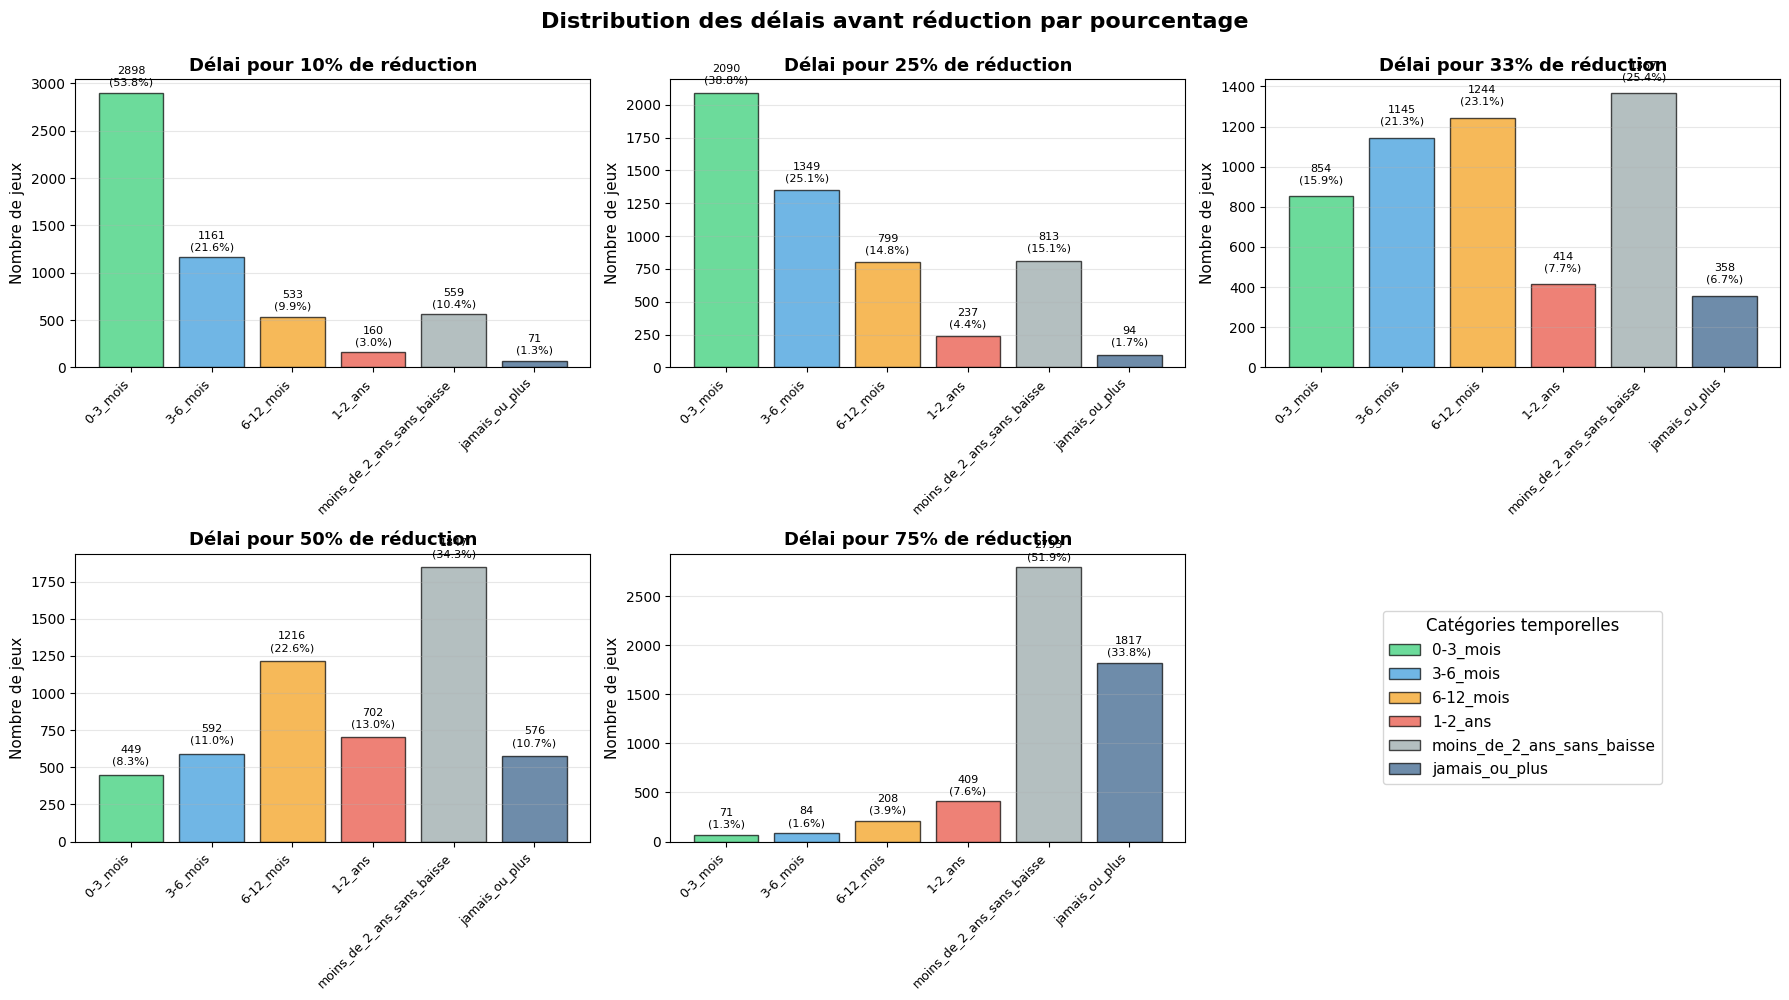

In [557]:
show_distribution_classe_wait_discount(df_days_to_discount)

### Création target reduction : classification binaire 50% réduction avant 1 an

Création également de deux autres target (distribution assez bien équilibré)

In [558]:
def create_binary_get_discount_before_time(df: pd.DataFrame, target_promo: int, year_delay = 2):
    """
    - 1 : Oui, a eu la réduction avant year_delay ans
    - 0 : Non, n'a jamais eu ou pas avant year_delay ans
    - None/NaN : Jeu trop récent (<year_delay ans) pour savoir
    """
    
    delay_days = year_delay * 365
    
    df_copy = df.copy()
    target_col = f'days_to_{target_promo}_percent_discount'
    col_name = f'has_{target_promo}_percent_discount_before_{year_delay}_year'
    
    # Initialiser à None partout
    df_copy[col_name] = None
    
    # Cas Jeu a eu la réduction ET avant delay_days
    mask_discount_before_y = (df_copy[target_col].notna()) & (df_copy[target_col] < delay_days)
    df_copy.loc[mask_discount_before_y, col_name] = 1
    
    # Cas Jeu JAMAIS eu la réduction OU réduction après year_delay ans
    # ET jeu assez ancien (>year_delay ans) pour etre sur
    mask_no_discount = (
        (df_copy['days_since_release'] >= delay_days) &  # Jeu ancien
        (
            (df_copy[target_col].isna()) |  # Jamais eu réduction
            (df_copy[target_col] >= delay_days)    # Réduction trop tard
        )
    )
    df_copy.loc[mask_no_discount, col_name] = 0
    
    # Cas Jeu récent (<year_delay ans) ,On ne peut pas savoir, reste None
    # Cas days_since_release est NaN reste None
    
    return df_copy

#### Vérification target 50% avant 1 an

In [559]:
df_days_to_discount = create_binary_get_discount_before_time(df_days_to_discount,50,1)
print(df_days_to_discount[f'has_{50}_percent_discount_before_{1}_year'].value_counts(dropna=False))

has_50_percent_discount_before_1_year
1       2245
0       1885
None    1252
Name: count, dtype: int64


#### Vérification target 75% avant 3 ans

In [560]:
df_days_to_discount = create_binary_get_discount_before_time(df_days_to_discount,75,3)
print(df_days_to_discount[f'has_{75}_percent_discount_before_{3}_year'].value_counts(dropna=False))

has_75_percent_discount_before_3_year
None    3619
1        964
0        799
Name: count, dtype: int64


#### Vérification target 33% avant 7 mois

In [561]:
df_days_to_discount = create_binary_get_discount_before_time(df_days_to_discount,33,0.6)
print(df_days_to_discount[f'has_{33}_percent_discount_before_{0.6}_year'].value_counts(dropna=False))

has_33_percent_discount_before_0.6_year
1       2418
0       2291
None     673
Name: count, dtype: int64


In [562]:
# has_33_percent_discount_before_0.6_year
# has_50_percent_discount_before_1_year
# has_75_percent_discount_before_3_year

In [563]:
def analyze_discount_thresholds(df:pd.DataFrame):
    # Les colonnes à analyser
    threshold_columns = [
        ('has_33_percent_discount_before_0.6_year', '33% avant 0.6 an (≈7 mois)'),
        ('has_50_percent_discount_before_1_year', '50% avant 1 an'),
        ('has_75_percent_discount_before_3_year', '75% avant 3 ans')
    ]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (col_name, title) in enumerate(threshold_columns):
        ax = axes[idx]
        ax:plt.Axes
        
        # Compter les valeurs
        value_counts = df[col_name].value_counts()
        
        # S'assurer que True et False sont présents
        true_count = value_counts.get(True, 0)
        false_count = value_counts.get(False, 0)
        total = true_count + false_count
        
        # Données
        categories = ['Oui', 'Non']
        counts = [true_count, false_count]
        colors = ['#2ecc71', '#e74c3c']
        
        # Barplot
        bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', width=0.6)
        ax.set_ylabel('Nombre de jeux', fontsize=12)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Ajouter les valeurs et pourcentages
        for bar, count in zip(bars, counts):
            pct = count / total * 100 if total > 0 else 0
            ax.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        # Limites y
        ax.set_ylim(0, max(counts) * 1.15)
    
    plt.suptitle('Jeux atteignant les seuils de réduction dans les délais cibles', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()


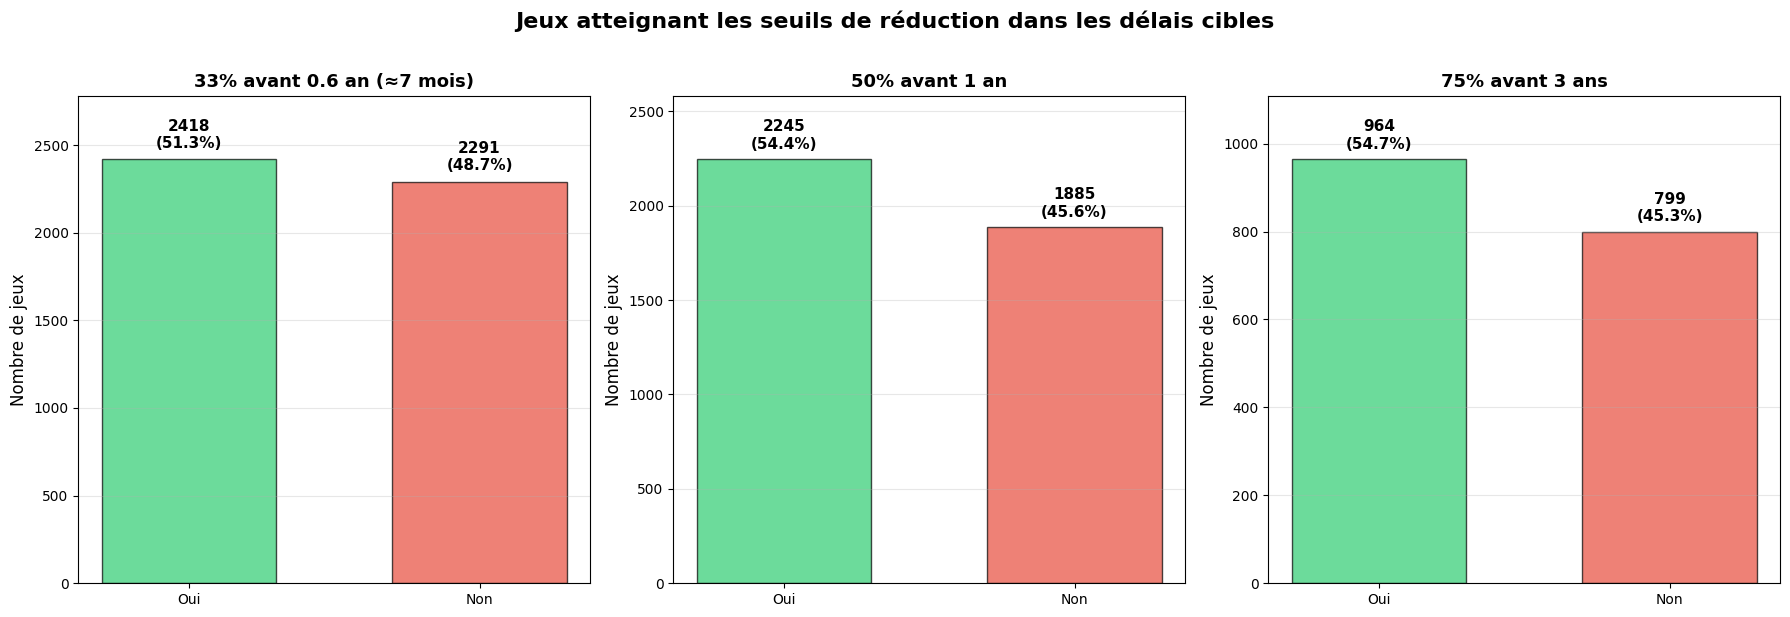

In [564]:
analyze_discount_thresholds(df_days_to_discount)

## Création features observation discount à + 60 jours après sortie

Afin d'aider la prédiction de baisse de prix, on a vu avec le métier qu'atendre 60 jours après la sortie pour avoir des premières tendances peut être intéressant.

In [565]:
def discount_percentage_at_days(
    sales_history, base_price, release_date, days_after_release
):
    """
    Retourne le pourcentage de réduction maximum atteint à un nombre de jours donné après la sortie
    """
    if release_date is None:
        return None

    if len(sales_history) == 0:
        return None

    if not isinstance(base_price, (int, float)) or base_price <= 0:
        return None
    
    if not isinstance(days_after_release, (int, float)) or days_after_release < 0:
        return None

    # Convertir release_date en datetime si c'est une string
    if isinstance(release_date, str):
        release_date = datetime.strptime(release_date, "%Y-%m-%d")

    # Calculer la date cible (release_date + X jours)
    target_date = release_date + timedelta(days=days_after_release)
    
    # Trouver le prix le plus bas AVANT ou À la date cible
    best_price = None
    
    for entry in sales_history:
        price = entry["y"]
        date_str = entry["x"]
        date = datetime.strptime(date_str, "%Y-%m-%d")

        # Ignorer les prix négatifs ou invalides
        if price < 0.1:
            continue

        # Ne considérer que les dates entre release_date et target_date (inclus)
        if release_date <= date <= target_date:
            if best_price is None or price < best_price:
                best_price = price

    # Si aucun prix trouvé, retourner None
    if best_price is None:
        return None

    # Calculer le pourcentage de réduction
    discount_percentage = ((base_price - best_price) / base_price) * 100
    
    return round(discount_percentage, 2)

In [566]:
def generate_discount_from_days_df_data(df:pd.DataFrame,days_after_release):
    col_name = f'{days_after_release}_days_after_release_percent_discount'
    df[col_name] = df.apply(
        lambda row: discount_percentage_at_days(
            row['price_history'], 
            row['base_price'], 
            row['release_date'], 
            days_after_release
        ),
        axis=1
    )
    return df

In [567]:
def add_discount_reached_flag(df: pd.DataFrame, days: int, discount_threshold: float) -> pd.DataFrame:
    """
    Ajoute une colonne binaire indiquant si le jeu a atteint au moins X% de réduction après Y jours
    """
    df_result = df.copy()
    discount_col = f'{days}_days_after_release_percent_discount'
    flag_col = f'has_{discount_threshold}pct_discount_at_{days}d'
    
    df_result[flag_col] = (
        df_result[discount_col].fillna(0) >= discount_threshold
    ).astype(int)
    
    return df_result

In [568]:
for discount in discount_helper:
    df_days_to_discount = generate_discount_from_days_df_data(df_days_to_discount, discount["days_from_release"])
    df_days_to_discount = add_discount_reached_flag(df_days_to_discount, days=discount["days_from_release"], discount_threshold=discount["percent_discount"])

    print(df_days_to_discount[f'has_{discount["percent_discount"]}pct_discount_at_{discount["days_from_release"]}d'].value_counts())
    print("\n")

has_5pct_discount_at_30d
0    4944
1     438
Name: count, dtype: int64


has_10pct_discount_at_60d
0    3548
1    1834
Name: count, dtype: int64




In [569]:
def analyze_early_discount_thresholds(df:pd.DataFrame):
    """Analyse des réductions précoces (30 et 60 jours)"""
    
    # Les colonnes à analyser
    threshold_columns = [
        ('has_5pct_discount_at_30d', '5% de réduction à 30 jours'),
        ('has_10pct_discount_at_60d', '10% de réduction à 60 jours')
    ]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for idx, (col_name, title) in enumerate(threshold_columns):
        ax = axes[idx]
        ax: plt.Axes
        
        # Compter les valeurs
        value_counts = df[col_name].value_counts()
        
        # S'assurer que True et False sont présents
        true_count = value_counts.get(1, 0)
        false_count = value_counts.get(0, 0)
        total = true_count + false_count
        
        # Données
        categories = ['Oui', 'Non']
        counts = [true_count, false_count]
        colors = ['#2ecc71', '#e74c3c']
        
        # Barplot
        bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', width=0.5)
        ax.set_ylabel('Nombre de jeux', fontsize=12)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        
        # Ajouter les valeurs et pourcentages
        for bar, count in zip(bars, counts):
            pct = count / total * 100 if total > 0 else 0
            ax.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                    fontsize=11, fontweight='bold')
        
        # Limites y
        ax.set_ylim(0, max(counts) * 1.15)
    
    plt.suptitle('Jeux avec réductions précoces (30 et 60 jours)', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()

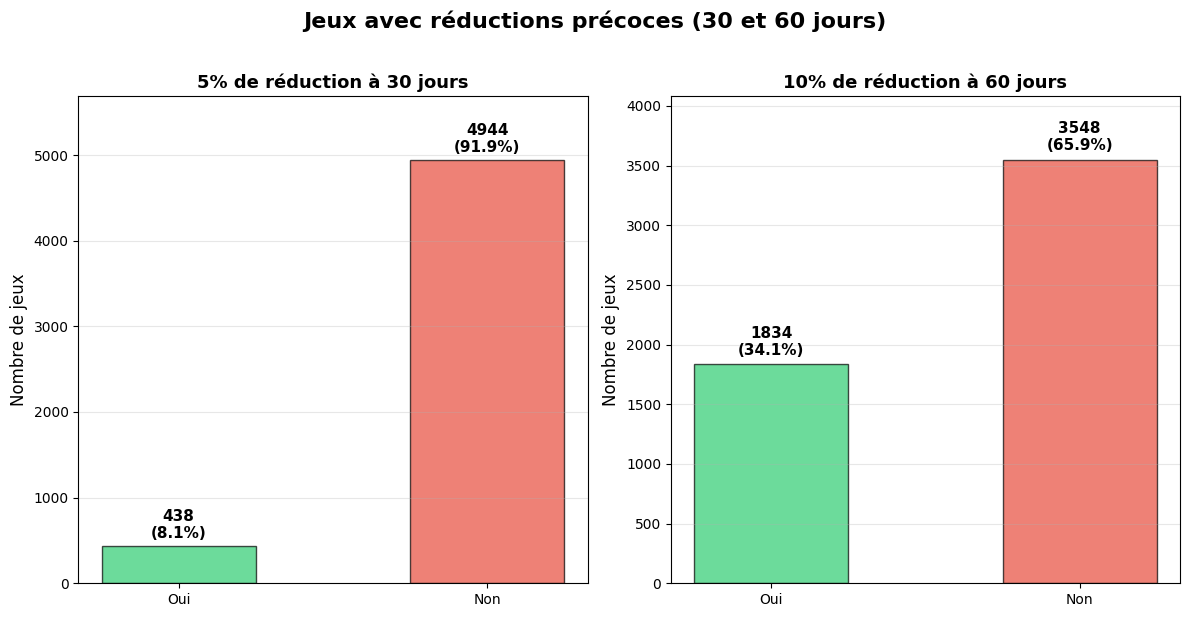

In [570]:
analyze_early_discount_thresholds(df_days_to_discount)

#### Intégration des targets à prédire dans le dataframe qui sera exporté pour l'entrainement des modèles

In [571]:
# concat dataframe features avec dataframe days to discount des nouvelles colonnes uniquement
for promo in PROMOS:
    col_name_regression = f'days_to_{promo}_percent_discount'
    df_featured = pd.concat([df_featured, df_days_to_discount[[col_name_regression]]], axis=1)
    col_name_classification = f'days_to_{promo}_percent_discount_category'
    df_featured = pd.concat([df_featured, df_days_to_discount[[col_name_classification]]], axis=1)
    
for discount in discount_helper:
    df_featured = pd.concat([df_featured, df_days_to_discount[[f'has_{discount["percent_discount"]}pct_discount_at_{discount["days_from_release"]}d']]], axis=1)
    
# has_33_percent_discount_before_0.6_year
# has_50_percent_discount_before_1_year
# has_75_percent_discount_before_3_year
binary_discount_target = ["has_33_percent_discount_before_0.6_year","has_50_percent_discount_before_1_year","has_75_percent_discount_before_3_year"]
df_featured[binary_discount_target] = df_days_to_discount[binary_discount_target].astype('Int64')

In [572]:
# On vérifie les colonnes ajoutées
column_summary(df_featured)

Résumé détaillé des colonnes:
                                 Column    Type  Non-Null Count  Null Count  Unique Values
                              game_name  object            5382           0           5382
                               id_store  object            5382           0           5382
                         short_url_name  object            5382           0           5382
                              publisher  object            5382           0           1061
                              developer  object            3920        1462           2709
                           release_date  object            5382           0           1347
                  pssstore_stars_rating float64            5382           0            352
            pssstore_stars_rating_count   int64            5382           0           1583
                metacritic_critic_score   Int64            1268        4114             67
            metacritic_critic_userscore   Int64            1

## Traitement éditeur / developer

In [573]:
df_publishers_importance = df_featured.copy()

### Création fichier avec valeur unique

In [574]:
# Classement basé sur profil éditeur, volume de sorties multi-plateformes, 
# présence sur consoles, spécialisation grands publics ou indépendant, 
# et réputation dans divers catalogues digitaux.

PUBLISHERS_BY_CATEGORY = {
    "aaa": [
        "sony interactive entertainment",
        "electronic arts",
        "ubisoft",
        "activision",
        "take-two interactive",
        "bethesda",
        "sega",
        "square enix",
        "bandai namco entertainment",
        "capcom",
        "konami",
        "koei tecmo",
        "warner bros",
        "disney interactive",
        "microsoft",
        "epic games",
        "rockstar games",
        "blizzard entertainment",
        "thq nordic",
        "amazon games",
    ],
    "aa": [
        "polyphony digital",
        "cd projekt",
        "crytek",
        "505 games",
        "focus entertainment",
        "deep silver",
        "devolver digital",
        "annapurna interactive",
        "team 17 digital",
        "team17",
        "tinybuild",
        "humble games",
        "nacon",
        "microids",
        "nis",
        "pqube",
        "xseed games",
        "aksys games",
        "frontier developments",
        "paradox interactive",
        "rebellion",
        "gameloft se",
        "lego system",
        "3d realms entertainment",
        "quantic dream",
        "eidos interactive"
    ],
    "indie_quality": [
        "auto slavic",
        "disco elysium uk ltd t/a za/um",
        "super powerup games",
        "top hat studios",
        "feardemic",
        "dolores entertainment",
        "silesia games",
        "happy player",
        "webnetic",
        "raw fury",
        "akupara games",
        "thunderful publishing",
        "playism",
        "daedalic entertainment",
        "dear villagers",
        "wales interactive",
        "untold tales",
        "headup games",
        "handy games",
        "cgi lab",
        "joindots",
        "y-zo studio",
        "aerosoft",
        "jandusoft",
        "afil games",
        "penguin pop games", 
        "markt+technik verlag",
        "armin unold",
        "zakym",
        "volkov konstantin sergeevich",
        "ggmuks",
        "nostra games",
        "gametry",
        "thigames",
        "smobile",
        "ocean media",
        "playstige interactive information and trade limited liability company",
        "oddworld inhabitants."
    ],
    "specialized": [
        "kemco",
        "atari",
        "hamster",
        "wayforward technologies",
        "arc system works",
        "milestone",
        "soedesco publishing",
        "benoit varasse trading as pix arts",
        "ratalaika games",
        "eastasiasoft",
        "qubyte interactive",
        "pix arts",
        "red art games",
    ]
}

In [575]:
def add_publisher_importance_category(df:pd.DataFrame):
    df_result = df.copy()
    
    def get_category(publisher):
        if pd.isna(publisher):
            return 'unknown'
        
        pub_lower = str(publisher).lower()
        
        for category, publishers in PUBLISHERS_BY_CATEGORY.items():
            if any(major in pub_lower for major in publishers):
                return category
        
        return 'other'
    
    df_result['publisher_category'] = df_result['publisher'].apply(get_category)
    
    return df_result

In [576]:
df_publishers_importance = add_publisher_importance_category(df_publishers_importance)
    
# Stats
print(df_publishers_importance['publisher_category'].value_counts())

publisher_category
other            2555
indie_quality    1321
specialized       720
aaa               405
aa                381
Name: count, dtype: int64


In [577]:
def add_publisher_game_count_with_category(df: pd.DataFrame) -> pd.DataFrame:
    df_result = df.copy()
    
    publisher_counts = df_result['publisher'].value_counts()
    
    # Mapper le comptage
    # TODO Log scale (pour éviter que les gros éditeurs dominent) avec np.log1p
    df_result['publisher_game_count'] = df_result['publisher'].map(publisher_counts).fillna(0).astype(int)
    
    # Créer des catégories de taille d'éditeur
    df_result['publisher_game_count_cat'] = pd.cut(
        df_result['publisher_game_count'],
        bins=[0, 1, 5, 20, 50, float('inf')],
        labels=['unique', 'small', 'medium', 'large', 'major']
    )
    
    return df_result

In [578]:
df_publishers_importance = add_publisher_game_count_with_category(df_publishers_importance)

print(f"Distribution par taille d'éditeur:")
print(df_publishers_importance['publisher_game_count_cat'].value_counts().sort_index())

Distribution par taille d'éditeur:
publisher_game_count_cat
unique     584
small      826
medium    1480
large      956
major     1536
Name: count, dtype: int64


In [579]:
df_featured = pd.concat([df_featured, df_publishers_importance[['publisher_category', 'publisher_game_count_cat', 'publisher_game_count']]], axis=1)

## Traitement de la colonne des genres

In [580]:
df_genres_proccess = df_featured.copy()

In [581]:
# Liste compléte des genres

# Action	
# Adventure	
# Arcade	
# Casual	
# FPS	
# Fighting	
# Horror	
# MMO	
# Music	
# Platformer	
# Puzzle	
# RPG	
# Racing	
# Simulation	
# Sports	
# Strategy	
# TPS


# Regroupement en genres principaux: 

# https://cnlj.bnf.fr/sites/default/files/cnlj-genres-jeux-video.pdf

# LES JEUX D’ACTION - AVENTURE : Action,FPS, TPS, Platformer, Adventure, Horror
# LES JEUX DE ROLES : MMO, RPG
# LES JEUX DE SPORTS : Sports, Racing, Fighting
# LES JEUX DE REFLEXION : Puzzle, Simulation, Strategy
# LES JEUX RAPIDE : Music, Casual, Arcade

# On supprime les colonnes inutiles
# df_genres_proccess.drop(['genres'], axis='columns', inplace=True)



In [582]:
# Configuration des regroupements de genres
GENRE_GROUPS = {
    'action_aventure': ['Action', 'FPS', 'TPS', 'Platformer', 'Adventure', 'Horror'],
    'roles': ['MMO', 'RPG'],
    'sports': ['Sports', 'Racing', 'Fighting'],
    'reflexion': ['Puzzle', 'Simulation', 'Strategy'],
    'rapide': ['Music', 'Casual', 'Arcade']
}

In [583]:
def create_grouped_genre_binary_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Crée des colonnes binaires pour les groupes de genres
    Un jeu peut appartenir à plusieurs groupes
    """
    df_result = df.copy()
    
    # Préparer les genres (split et strip)
    genres_lists = df_result['genres'].fillna('').str.split(',').apply(
        lambda x: [genre.strip() for genre in x if genre.strip()]
    )
    
    # Créer les colonnes binaires pour chaque groupe
    for group_name, group_genres in GENRE_GROUPS.items():
        df_result[f'genre_{group_name}'] = genres_lists.apply(
            lambda genres: int(any(genre in group_genres for genre in genres))
        )
    
    genre_columns = [f'genre_{group}' for group in GENRE_GROUPS.keys()]
    genre_df = df_result[genre_columns].copy()
    
    # S'assurer que toutes les valeurs sont 0 ou 1
    genre_df = genre_df.fillna(0).astype(int)
    
    return genre_df

In [584]:
df_genres_grouped = create_grouped_genre_binary_columns(df_genres_proccess)

# Vérifier le résultat
print("\nColonnes créées:")
print(df_genres_grouped.columns.tolist())
print(f"\nAperçu:")
print(df_genres_grouped.head(10))


Colonnes créées:
['genre_action_aventure', 'genre_roles', 'genre_sports', 'genre_reflexion', 'genre_rapide']

Aperçu:
   genre_action_aventure  genre_roles  genre_sports  genre_reflexion  \
0                      0            0             0                1   
1                      1            0             0                1   
2                      0            0             0                1   
3                      0            0             0                1   
4                      0            0             0                1   
5                      1            0             0                1   
6                      0            0             0                1   
7                      0            0             0                1   
8                      0            0             0                1   
9                      1            0             0                0   

   genre_rapide  
0             0  
1             0  
2             0  
3             1 

In [585]:
# Stats
print("Distribution des groupes de genres:")
print("=" * 60)
for col in df_genres_grouped:
    count = df_genres_grouped[col].sum()
    pct = count / len(df_genres_grouped) * 100
    print(f"   {col:30s}: {count:5d} jeux ({pct:5.1f}%)")

# Vérifier les jeux multi-groupes
total_assignments = df_genres_grouped.sum(axis=1)
print(f"\nNombre de groupes par jeu:")
print(f"   Sans groupe: {(total_assignments == 0).sum()}")
print(f"   1 groupe: {(total_assignments == 1).sum()}")
print(f"   2 groupes: {(total_assignments == 2).sum()}")
print(f"   3+ groupes: {(total_assignments >= 3).sum()}")

Distribution des groupes de genres:
   genre_action_aventure         :  4005 jeux ( 74.4%)
   genre_roles                   :  1044 jeux ( 19.4%)
   genre_sports                  :   736 jeux ( 13.7%)
   genre_reflexion               :  2582 jeux ( 48.0%)
   genre_rapide                  :  2805 jeux ( 52.1%)

Nombre de groupes par jeu:
   Sans groupe: 22
   1 groupe: 1506
   2 groupes: 2202
   3+ groupes: 1652


In [586]:
def analyze_genre_groups(df:pd.DataFrame):
    
    genre_columns = ['genre_action_aventure', 'genre_roles', 'genre_sports', 
                     'genre_reflexion', 'genre_rapide']
    
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Compter les jeux par genre
    genre_counts = {}
    for col in genre_columns:
        genre_counts[col] = df[col].sum()
    
    # Noms plus lisibles
    genre_labels = {
        'genre_action_aventure': 'Action/Aventure',
        'genre_roles': 'RPG',
        'genre_sports': 'Sports',
        'genre_reflexion': 'Réflexion',
        'genre_rapide': 'Rapide/Arcade'
    }
    
    # Préparer les données
    labels = [genre_labels[col] for col in genre_columns]
    counts = [genre_counts[col] for col in genre_columns]
    total = len(df)
    
    # Couleurs
    colors = ['#e74c3c', '#9b59b6', '#3498db', '#f39c12', '#2ecc71']
    
    # Barplot horizontal
    bars = ax.barh(labels, counts, color=colors, alpha=0.7, edgecolor='black')
    
    ax.set_xlabel('Nombre de jeux', fontsize=13)
    ax.set_title('Distribution des groupes de genres', fontsize=15, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Ajouter les valeurs et pourcentages
    for bar, count in zip(bars, counts):
        pct = count / total * 100
        ax.text(count + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                f'{count} ({pct:.1f}%)', va='center', fontsize=11, fontweight='bold')
    
    # Ajouter info multi-groupes
    total_assignments = df[genre_columns].sum(axis=1)
    multi_info = f"Jeux multi-groupes: {(total_assignments > 1).sum()} ({(total_assignments > 1).sum()/total*100:.1f}%)"
    ax.text(0.98, 0.02, multi_info, transform=ax.transAxes, 
            fontsize=10, va='bottom', ha='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()

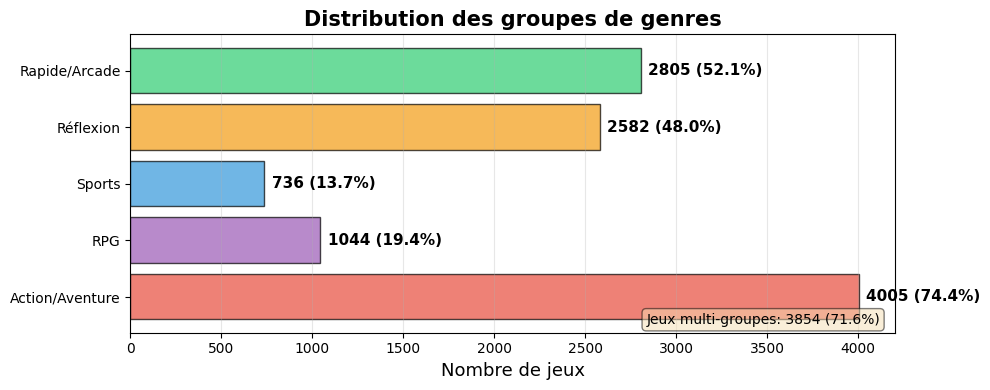

In [587]:
analyze_genre_groups(df_genres_grouped)

In [588]:
# Merge avec df_featured
df_featured = pd.concat([df_featured, df_genres_grouped], axis=1)

In [589]:
column_summary(df_featured)

Résumé détaillé des colonnes:
                                 Column     Type  Non-Null Count  Null Count  Unique Values
                              game_name   object            5382           0           5382
                               id_store   object            5382           0           5382
                         short_url_name   object            5382           0           5382
                              publisher   object            5382           0           1061
                              developer   object            3920        1462           2709
                           release_date   object            5382           0           1347
                  pssstore_stars_rating  float64            5382           0            352
            pssstore_stars_rating_count    int64            5382           0           1583
                metacritic_critic_score    Int64            1268        4114             67
            metacritic_critic_userscore    Int64  

## Popularity score

A partir de la colonne la plus intéressante et compléte (psstore vote) et pondération en fonction de l'âge du jeu

Très utile pour observation à J+60 (âge du jeu pondération)

In [590]:
df_popularity_score = df_featured.copy()

In [591]:
def add_popularity_score(df: pd.DataFrame) -> pd.DataFrame:
    df_result = df.copy()
    
    # Calculs
    days = df_result['days_since_release'].fillna(1).clip(lower=1)
    reviews = df_result['pssstore_stars_rating_count'].fillna(0)
    reviews_per_day = reviews / days
    
    # Score basé sur le rang percentile (0-100)
    # Garantit une distribution équilibrée
    reviews_rank = reviews.rank(pct=True) * 100
    rpd_rank = reviews_per_day.rank(pct=True) * 100
    
    # Combiner : 60% volume + 40% momentum
    df_result['popularity_score'] = (
        reviews_rank * 0.6 + rpd_rank * 0.4
    ).round(1)
    
    # Catégories
    df_result['popularity_category'] = pd.cut(
        df_result['popularity_score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['very_low', 'low', 'medium', 'high', 'very_high'],
        include_lowest=True
    )
    
    return df_result

In [592]:
df_popularity_score = add_popularity_score(df_popularity_score)

# Stats
print(f"Popularity Score (0-100):")
print(f"   Médiane: {df_popularity_score['popularity_score'].median():.1f}")
print(f"   Moyenne: {df_popularity_score['popularity_score'].mean():.1f}")
print(f"\n   Distribution:")
print(df_popularity_score['popularity_category'].value_counts().sort_index())

Popularity Score (0-100):
   Médiane: 48.5
   Moyenne: 50.0

   Distribution:
popularity_category
very_low      985
low          1200
medium       1135
high         1015
very_high    1047
Name: count, dtype: int64


In [593]:
def analyze_popularity_category(df:pd.DataFrame):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax:plt.Axes
    
    # Ordre logique des catégories
    category_order = ['very_low', 'low', 'medium', 'high', 'very_high']
    
    # Compter les valeurs
    popularity_counts = df['popularity_category'].value_counts()
    popularity_counts = popularity_counts.reindex(category_order, fill_value=0)
    
    # Labels plus lisibles
    labels = ['Très faible', 'Faible', 'Moyenne', 'Élevée', 'Très élevée']
    
    # Couleurs (gradient)
    colors = ['#95a5a6', '#bdc3c7', '#f39c12', '#e67e22', '#e74c3c']
    
    # Barplot
    bars = ax.bar(labels, popularity_counts.values, color=colors, 
                  alpha=0.7, edgecolor='black')
    
    ax.set_ylabel('Nombre de jeux', fontsize=13)
    ax.set_xlabel('Catégorie de popularité', fontsize=13)
    ax.set_title('Distribution de la popularité des jeux\n\n', fontsize=15, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs et pourcentages
    total = popularity_counts.sum()
    for bar, count in zip(bars, popularity_counts.values):
        pct = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    
    print(f"\n--- MOYENNES PAR CATÉGORIE ---")
    category_order = ['very_low', 'low', 'medium', 'high', 'very_high']
    labels = ['Très faible', 'Faible', 'Moyenne', 'Élevée', 'Très élevée']
    for cat, label in zip(category_order, labels):
        avg = df[df['popularity_category'] == cat]["popularity_score"].mean()
        print(f"  {label:15s}: {avg:.2f}")


--- MOYENNES PAR CATÉGORIE ---
  Très faible    : 11.18
  Faible         : 29.98
  Moyenne        : 49.88
  Élevée         : 70.37
  Très élevée    : 89.89


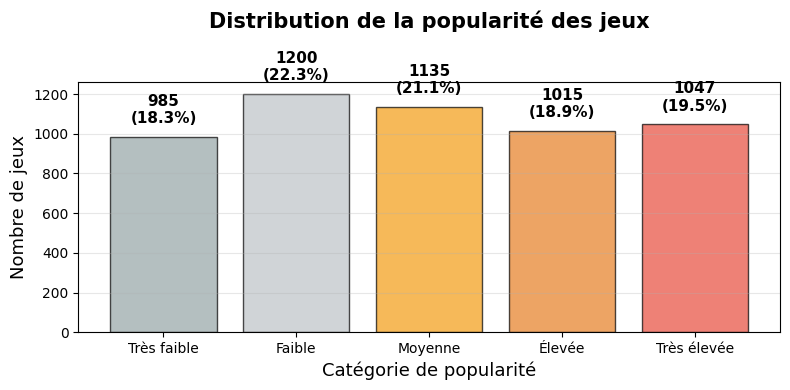

In [594]:
analyze_popularity_category(df_popularity_score)

In [595]:
df_featured = pd.concat([df_featured, df_popularity_score[['popularity_score', 'popularity_category']]], axis=1)

## Score contenu riche

Agrégation de plusieurs colonnes portant sur les fonctionnalités.

- Score composite de contenu/richesse du jeu (0-100)
- Score élevé = jeu avec beaucoup de fonctionnalités et contenus
- Score faible = jeu minimaliste ou peu détaillé

In [596]:
df_score_content = df_featured.copy()

In [597]:
def add_languages_count(df: pd.DataFrame) -> pd.DataFrame:
    df_result = df.copy()
    
    # Compter le nombre de voices
    df_result['voice_languages_count'] = df_result['voice_languages'].apply(
        lambda x: len([lang.strip() for lang in str(x).split(',') if lang.strip()]) 
        if pd.notna(x) else None
    )
    
    # Compter le nombre de subs
    df_result['sub_languages_count'] = df_result['subtitle_languages'].apply(
        lambda x: len([lang.strip() for lang in str(x).split(',') if lang.strip()]) 
        if pd.notna(x) else None
    )
    
    return df_result

In [598]:
df_score_content = add_languages_count(df_score_content)
lang_stats = ['voice_languages_count','sub_languages_count']

for l in lang_stats:
    print(f"\nStatistiques sur le nombre de {l}:")
    
    print_nan_stats(df_score_content, l)
    
    print(f"\n    Min: {df_score_content[l].min()}")
    print(f"    Max: {df_score_content[l].max()}")
    print(f"    Moyenne: {df_score_content[l].mean():.1f}")
    print(f"    Médiane: {df_score_content[l].median():.0f}")


Statistiques sur le nombre de voice_languages_count:
    NaN: 2821 (52.4%)
    Non-NaN: 2561 (47.6%)

    Min: 1.0
    Max: 17.0
    Moyenne: 2.0
    Médiane: 1

Statistiques sur le nombre de sub_languages_count:
    NaN: 1620 (30.1%)
    Non-NaN: 3762 (69.9%)

    Min: 1.0
    Max: 44.0
    Moyenne: 5.9
    Médiane: 5


In [599]:
def add_localization_classification(df: pd.DataFrame) -> pd.DataFrame:
    df_result = df.copy()
    
    voice = df_result['voice_languages_count'].fillna(0)
    subs = df_result['sub_languages_count'].fillna(0)
    
    # Score brut
    raw_score = (voice * 3) + subs
    df_result['localization_raw_score'] = raw_score
    
    # Classification basée sur les seuils observés
    def classify_localization(score, voice_count, sub_count):
        # Aucune localisation
        if score == 0:
            return 'none'
        
        # Localisation minimale (< médiane, environ score < 5)
        elif score <= 5:
            return 'minimal'
        
        # Localisation basique (score 6-15, environ)
        elif score <= 15:
            return 'basic'
        
        # Localisation standard (score 16-30)
        elif score <= 30:
            return 'standard'
        
        # Bonne localisation (score 31-50)
        elif score <= 50:
            return 'good'
        
        # Excellente localisation (score > 50)
        else:
            return 'excellent'
    
    df_result['localization_category'] = df_result.apply(
        lambda row: classify_localization(
            row['localization_raw_score'],
            row['voice_languages_count'],
            row['sub_languages_count']
        ),
        axis=1
    )
    
    # Score normalisé 0-100 (percentile rank)
    df_result['localization_score'] = df_result['localization_raw_score'].rank(pct=True) * 100
    df_result['localization_score'] = df_result['localization_score'].round(0)
    
    return df_result

In [600]:
df_score_content = add_localization_classification(df_score_content)

print(f"\nDistribution par tier:")
print(df_score_content['localization_category'].value_counts().sort_index())


Distribution par tier:
localization_category
basic        1943
excellent      27
good           98
minimal      1171
none         1620
standard      523
Name: count, dtype: int64


In [601]:
def add_download_size_features(df: pd.DataFrame) -> pd.DataFrame:

    df_result = df.copy()
    
    # Conversion en GB
    df_result['download_size_gb'] = df_result['download_size'] / (1024 ** 3)
    df_result['download_size_gb'] = df_result['download_size_gb'].round(2)
    
    # Catégories de taille
    df_result['download_size_category'] = pd.cut(
        df_result['download_size_gb'],
        bins=[0, 1, 5, 20, 50, float('inf')],
        labels=['tiny', 'small', 'medium', 'large', 'huge']
    )
    
    # df_result['has_size_info'] = df_result['download_size_gb'].notna().astype(int)
    
    return df_result

In [602]:
df_score_content = add_download_size_features(df_score_content)

print(f"Statistiques de taille de téléchargement:")
print_nan_stats(df_score_content, "download_size_gb")
print(f"\n    Min: {df_score_content['download_size_gb'].min():.2f} GB")
print(f"    Max: {df_score_content['download_size_gb'].max():.2f} GB")
print(f"    Moyenne: {df_score_content['download_size_gb'].mean():.2f} GB")
print(f"    Médiane: {df_score_content['download_size_gb'].median():.2f} GB")

print(f"\nDistribution par catégorie:")
print(df_score_content['download_size_category'].value_counts().sort_index())

Statistiques de taille de téléchargement:
    NaN: 2854 (53.0%)
    Non-NaN: 2528 (47.0%)

    Min: 0.00 GB
    Max: 137.81 GB
    Moyenne: 5.90 GB
    Médiane: 0.82 GB

Distribution par catégorie:
download_size_category
tiny      1344
small      623
medium     339
large      159
huge        61
Name: count, dtype: int64


In [603]:
completion_stats = ['hours_main_story','hours_completionist']

for l in completion_stats:
    print(f"\nStatistiques sur le nombre de {l}:\n")
    print_nan_stats(df_score_content, l)
    print(f"\n    Min: {df_score_content[l].min()} h")
    print(f"    Max: {df_score_content[l].max()} h")
    print(f"    Moyenne: {df_score_content[l].mean():.1f} h")
    print(f"    Médiane: {df_score_content[l].median():.0f} h")


Statistiques sur le nombre de hours_main_story:

    NaN: 2029 (37.7%)
    Non-NaN: 3353 (62.3%)

    Min: 0 h
    Max: 1000 h
    Moyenne: 10.3 h
    Médiane: 5 h

Statistiques sur le nombre de hours_completionist:

    NaN: 2477 (46.0%)
    Non-NaN: 2905 (54.0%)

    Min: 0 h
    Max: 1500 h
    Moyenne: 11.5 h
    Médiane: 5 h


In [ ]:
def calculate_content_score(df: pd.DataFrame) -> pd.DataFrame:

    # Calcule un score composite de contenu/richesse du jeu (0-100)
    # Score élevé = jeu avec beaucoup de fonctionnalités et contenus
    # Score faible = jeu minimaliste ou peu détaillé

    df_result = df.copy()
    score = pd.Series(0, index=df_result.index, dtype=float) # Initialiser le score à 0
    
    score -= (df_result['base_price'] < 4.9).astype(int) * 3 # Prix très bas (< 5€) - souvent des jeux asset flip ou très simples
    score -= df_result['trophies_count'].isna().astype(int) * 2 # Pas d'info trophées
    
    score -= (df_result['localization_category'] == 'none').astype(int) * 3 # Aucune localisation
    no_duration_info = (df_result['hours_main_story'].isna() & 
                        df_result['hours_completionist'].isna())
    score -= no_duration_info.astype(int) * 2 # Pas d'info de durée de jeu
    score -= df_result['download_size_gb'].isna().astype(int) * 1# Pas d'info de taille (souvent = pas de données fiables)
    
    main_story = df_result['hours_main_story'].fillna(0)
    score += np.where(main_story >= 20, 5, 0)  # Jeu long (20h+)
    score += np.where((main_story >= 10) & (main_story < 20), 3, 0)  # Moyen (10-20h)
    score += np.where((main_story >= 5) & (main_story < 10), 1, 0)  # Court (5-10h)
    
    completionist = df_result['hours_completionist'].fillna(0)
    score += np.where(completionist >= 50, 5, 0)  # Très long
    score += np.where((completionist >= 20) & (completionist < 50), 3, 0)  # Long
    score += np.where((completionist >= 10) & (completionist < 20), 2, 0)  # Moyen
    
    score += (df_result['download_size_category'] == 'huge').astype(int) * 5  # 50+ GB
    score += (df_result['download_size_category'] == 'large').astype(int) * 4  # 20-50 GB
    score += (df_result['download_size_category'] == 'medium').astype(int) * 2  # 5-20 GB
    score += (df_result['download_size_category'] == 'small').astype(int) * 1  # 1-5 GB

    score += (df_result['localization_category'] == 'excellent').astype(int) * 5
    score += (df_result['localization_category'] == 'good').astype(int) * 4
    score += (df_result['localization_category'] == 'standard').astype(int) * 3
    score += (df_result['localization_category'] == 'basic').astype(int) * 1
      
    trophy_count = df_result['trophies_count'].fillna(0)
    score += np.where(trophy_count >= 50, 3, 0)  # Beaucoup de trophées
    score += np.where((trophy_count >= 20) & (trophy_count < 50), 2, 0)
    score += np.where((trophy_count > 0) & (trophy_count < 20), 1, 0)
    
    score += df_result['is_vr'].fillna(0).astype(int) * 3
    score += df_result['has_local_multiplayer'].fillna(0).astype(int) * 2
    score += df_result['has_online_multiplayer'].fillna(0).astype(int) * 3
    
    dlc_count = df_result['dlcs_count'].fillna(0)
    score += np.where(dlc_count >= 10, 4, 0)
    score += np.where((dlc_count >= 5) & (dlc_count < 10), 3, 0)
    score += np.where((dlc_count >= 1) & (dlc_count < 5), 1, 0)
    
    deluxe_count = df_result['packs_deluxe_count'].fillna(0)
    score += np.where(deluxe_count >= 3, 3, 0)
    score += np.where((deluxe_count > 0) & (deluxe_count < 3), 1, 0)
      
    score += df_result['metacritic_critic_score'].notna().astype(int) * 3

    # Popularité ajustée à l'âge du jeu
    days = df_result['days_since_release'].fillna(1).clip(lower=1)
    reviews = df_result['pssstore_stars_rating_count'].fillna(0)
    reviews_per_day = reviews / days
    
    # Calculer les percentiles pour des seuils adaptatifs
    # (évite les problèmes avec les outliers)
    p90 = reviews_per_day.quantile(0.90)  # Top 10%
    p75 = reviews_per_day.quantile(0.75)  # Top 25%
    p50 = reviews_per_day.quantile(0.50)  # Médiane
    p25 = reviews_per_day.quantile(0.25)  # Bottom 25%
    
    # Attribuer des points selon le momentum (reviews/jour)
    score += np.where(reviews_per_day >= p90, 6, 0)  # Très populaire
    score += np.where((reviews_per_day >= p75) & (reviews_per_day < p90), 4, 0)  # Populaire
    score += np.where((reviews_per_day >= p50) & (reviews_per_day < p75), 2, 0)  # Moyen
    score += np.where((reviews_per_day >= p25) & (reviews_per_day < p50), 1, 0)  # Faible
    
    # Bonus pour volume absolu (même pour vieux jeux)
    score += np.where(reviews >= 1000, 3, 0)  # Beaucoup d'avis
    score += np.where((reviews >= 100) & (reviews < 1000), 2, 0)  # Pas mal d'avis
    score += np.where((reviews >= 10) & (reviews < 100), 1, 0)  # Quelques avis
    
    # Pénalité pour absence totale d'avis
    score -= (reviews < 10).astype(int) * 2
    
    df_result['content_score_raw'] = score # Score brut
    
    # Normaliser sur 0-100 en utilisant les percentiles (évite que les outliers faussent tout)
    p_min = score.quantile(0.05)  # 5e percentile
    p_max = score.quantile(0.95)  # 95e percentile
    
    df_result['content_score'] = ((score - p_min) / (p_max - p_min) * 100).clip(0, 100).round(0)
    
    # Catégories de contenu
    df_result['content_category'] = pd.cut(
        df_result['content_score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['minimal', 'light', 'standard', 'rich', 'extensive'],
        include_lowest=True
    )
    return df_result

In [605]:
df_score_content = calculate_content_score(df_score_content)

print("SCORE DE CONTENU (Content Score):")
print("="*60)

print(f"\nScore normalisé (0-100):")
print(f"   Min: {df_score_content['content_score'].min():.0f}")
print(f"   Max: {df_score_content['content_score'].max():.0f}")
print(f"   Moyenne: {df_score_content['content_score'].mean():.1f}")
print(f"   Médiane: {df_score_content['content_score'].median():.0f}")

print(f"\nDistribution par tier:")
tier_counts = df_score_content['content_category'].value_counts().sort_index()
for tier in ['minimal', 'light', 'standard', 'rich', 'extensive']:
    if tier in tier_counts.index:
        count = tier_counts[tier]
        pct = count / len(df_score_content) * 100
        print(f"   {tier:12s}: {count:4d} ({pct:5.1f}%)")

SCORE DE CONTENU (Content Score):



Score normalisé (0-100):
   Min: 0
   Max: 100
   Moyenne: 36.7
   Médiane: 28

Distribution par tier:
   minimal     : 1799 ( 33.4%)
   light       : 1537 ( 28.6%)
   standard    :  948 ( 17.6%)
   rich        :  509 (  9.5%)
   extensive   :  589 ( 10.9%)


In [606]:
def analyze_content_score(df:pd.DataFrame): 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1:plt.Axes
    ax2:plt.Axes
    
    score_column = "content_score"
    
    # Distribution du score continu
    ax1.hist(df[score_column], bins=50, color='purple', alpha=0.7, edgecolor='black')
    ax1.axvline(df[score_column].median(), color='red', linestyle='--',
                linewidth=2, label=f"Médiane: {df[score_column].median():.1f}")
    ax1.axvline(df[score_column].mean(), color='orange', linestyle='--',
                linewidth=2, label=f"Moyenne: {df[score_column].mean():.1f}")
    
    ax1.set_xlabel('Score de contenu', fontsize=12)
    ax1.set_ylabel('Nombre de jeux', fontsize=12)
    ax1.set_title('Distribution du score de contenu\n', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(axis='y', alpha=0.3)
    
    # Distribution par cat
    tier_order = ['minimal', 'light', 'standard', 'rich', 'extensive']
    labels = ['Minimal', 'Light', 'Standard', 'Rich', 'Extensive']
    colors = ['#95a5a6', '#bdc3c7', '#3498db', '#9b59b6', '#e74c3c']
    
    tier_counts = df['content_category'].value_counts()
    tier_counts = tier_counts.reindex(tier_order, fill_value=0)
    
    bars = ax2.bar(labels, tier_counts.values, color=colors, 
                    alpha=0.7, edgecolor='black')
    
    ax2.set_ylabel('Nombre de jeux', fontsize=12)
    ax2.set_xlabel('Tier de contenu', fontsize=12)
    ax2.set_title('Distribution par tier de contenu\n', fontsize=14, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Ajouter valeurs et pourcentages
    total = tier_counts.sum()
    for bar, count in zip(bars, tier_counts.values):
        pct = count / total * 100
        ax2.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')

    
    plt.suptitle('Analyse du score de contenu\n', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

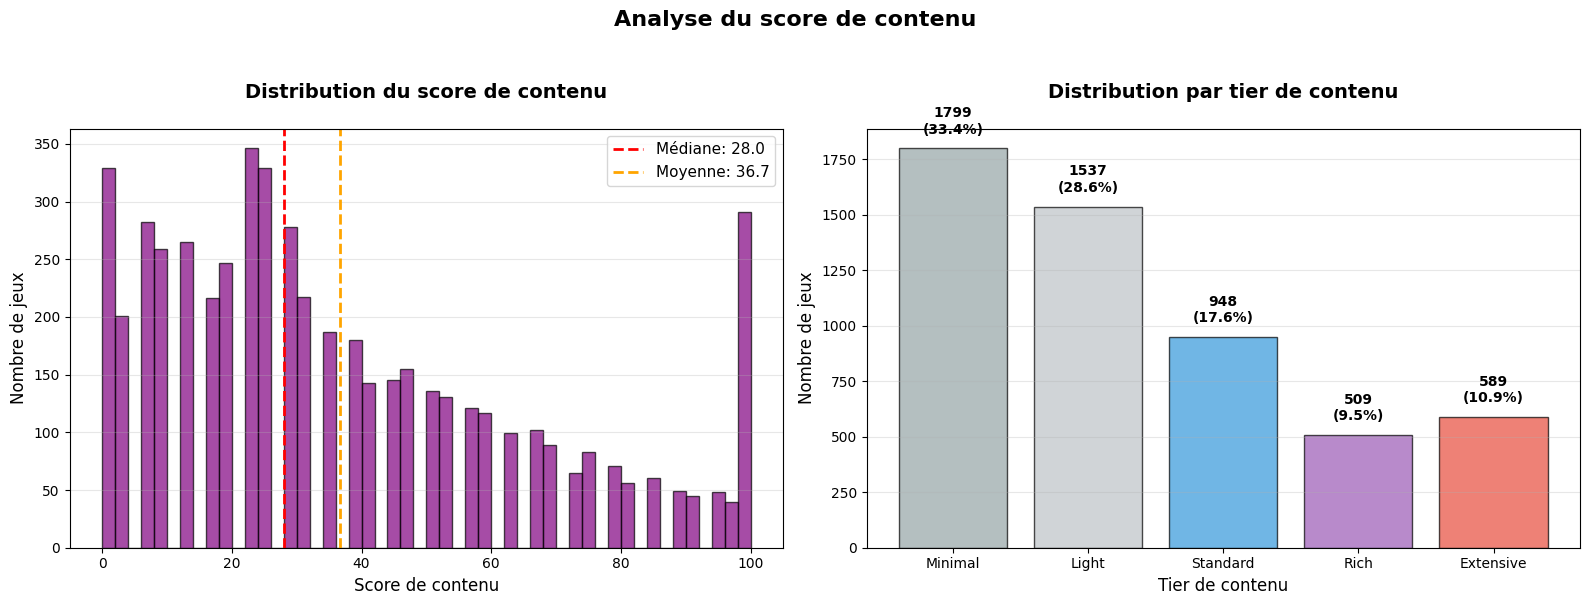

In [607]:
analyze_content_score(df_score_content)

### Intégration des features dans le dataframe qui sera exporté pour l'entrainement des modèles

In [608]:
df_featured = pd.concat([df_featured, df_score_content[['download_size_gb',
                                                        'download_size_category',
                                                        'voice_languages_count',
                                                        'localization_category',
                                                        'sub_languages_count',
                                                        'content_score',
                                                        'content_category']]], axis=1)

In [609]:
column_summary(df_featured)

Résumé détaillé des colonnes:
                                 Column     Type  Non-Null Count  Null Count  Unique Values
                              game_name   object            5382           0           5382
                               id_store   object            5382           0           5382
                         short_url_name   object            5382           0           5382
                              publisher   object            5382           0           1061
                              developer   object            3920        1462           2709
                           release_date   object            5382           0           1347
                  pssstore_stars_rating  float64            5382           0            352
            pssstore_stars_rating_count    int64            5382           0           1583
                metacritic_critic_score    Int64            1268        4114             67
            metacritic_critic_userscore    Int64  

## Feature combiné contenu exclusif playstation

In [610]:
df_exclusif_playstation_content = df_featured.copy()

In [611]:
# playstaion_exclu_content (is_ps_exclusive or is_opti_ps5_pro or is_vr)

def create_exclusif_playstation_content_feature(df:pd.DataFrame):
    df['exclusif_playstation_content'] = (
        (df['is_ps_exclusive'] == 1) | 
        (df['is_opti_ps5_pro'] == 1) | 
        (df['is_vr'] == 1)
    ).astype(int)
    
    return df

In [612]:
df_exclusif_playstation_content = create_exclusif_playstation_content_feature(df_exclusif_playstation_content)

In [613]:
print("Distribution contenu exclusif playstation:")
print("=" * 60)
total_assignments = df_exclusif_playstation_content['exclusif_playstation_content']
count_yes = (total_assignments == 1).sum()
pct_yes = count_yes / len(df_exclusif_playstation_content) * 100
print(f"   Oui: {count_yes:5d} jeux ({pct_yes:5.1f}%)")

count_yes = (total_assignments == 0).sum()
pct_yes = count_yes / len(df_exclusif_playstation_content) * 100
print(f"   Non: {count_yes:5d} jeux ({pct_yes:5.1f}%)")
    

Distribution contenu exclusif playstation:
   Oui:   480 jeux (  8.9%)
   Non:  4902 jeux ( 91.1%)


In [614]:
df_featured = pd.concat([df_featured, df_exclusif_playstation_content[['exclusif_playstation_content']]], axis=1)

## Score visibilité médiatisé / peu médiatisé

Combiner des signaux faibles en un score composite fort
Indicateurs négatifs jeu inconnu/peu médiatisé
Indicateurs positifs (jeu connu/médiatisé)

In [615]:
df_visibility_score = df_featured.copy()

In [616]:

import pandas as pd
import numpy as np

def calculate_visibility_score(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calcule un score de visibilité/médiatisation du jeu (0-100)
    Score élevé = jeu très connu, médiatisé, visible
    Score faible = jeu inconnu, peu de données, peu médiatisé
    """
    df_result = df.copy()
    
    # Initialiser le score à 0
    score = pd.Series(0, index=df_result.index, dtype=float)
    
    score -= (df_result['base_price'] < 4.9).astype(int) * 3 # Prix très bas (< 5€) - souvent peu de marketing
    score -= df_result['trophies_count'].isna().astype(int) * 2 # Pas d'info trophées (jeu peu documenté)
    score -= (df_result['pssstore_stars_rating_count'].fillna(0) < 10).astype(int) * 3# Très peu ou pas d'avis (< 10)
    score -= df_result['metacritic_critic_score'].isna().astype(int) * 2 # Pas de score critique (pas de coverage media)
    score -= (df_result['publisher_category'] == 'other').astype(int) * 2 # Pas d'éditeur connu
    
    # Éditeurs majeurs = grande visibilité
    score += (df_result['publisher_category'] == 'aaa').astype(int) * 10
    score += (df_result['publisher_category'] == 'aa').astype(int) * 6
    score += (df_result['publisher_category'] == 'indie_quality').astype(int) * 4
    score += (df_result['publisher_category'] == 'specialized').astype(int) * 3
    
    # Nombre de jeux de l'éditeur (proxy de présence sur la plateforme)
    publisher_count = df_result['publisher_game_count'].fillna(0)
    score += np.where(publisher_count >= 50, 4, 0)  # Éditeur très présent
    score += np.where((publisher_count >= 20) & (publisher_count < 50), 3, 0)
    score += np.where((publisher_count >= 10) & (publisher_count < 20), 2, 0)
    score += np.where((publisher_count >= 5) & (publisher_count < 10), 1, 0)
    

    pop_score = df_result['popularity_score'].fillna(0)
    score += (pop_score / 100 * 12)
     
    score += df_result['metacritic_critic_score'].notna().astype(int) * 4
    metacritic = df_result['metacritic_critic_score'].fillna(0)
    
    score += np.where(metacritic >= 80, 4, 0)  # Très bien noté
    score += np.where((metacritic >= 70) & (metacritic < 80), 2, 0)  # Bien noté
    
    reviews = df_result['pssstore_stars_rating_count'].fillna(0)
    score += np.where(reviews >= 1000, 5, 0)
    score += np.where((reviews >= 500) & (reviews < 1000), 4, 0)
    score += np.where((reviews >= 100) & (reviews < 500), 3, 0)
    score += np.where((reviews >= 50) & (reviews < 100), 2, 0)
    score += np.where((reviews >= 10) & (reviews < 50), 1, 0)
       
    # DLCs (signe d'un jeu supporté)
    dlc_count = df_result['dlcs_count'].fillna(0)
    score += np.where(dlc_count >= 10, 4, 0)
    score += np.where((dlc_count >= 5) & (dlc_count < 10), 3, 0)
    score += np.where((dlc_count >= 1) & (dlc_count < 5), 2, 0)
    
    # Éditions deluxe/premium (marketing)
    deluxe_count = df_result['packs_deluxe_count'].fillna(0)
    score += np.where(deluxe_count >= 2, 3, 0)
    score += np.where(deluxe_count == 1, 1, 0)
       
    # Informations de durée de jeu
    score += df_result['hours_main_story'].notna().astype(int) * 2
    score += df_result['hours_completionist'].notna().astype(int) * 1
    
    # Informations de difficulté
    score += df_result['difficulty'].notna().astype(int) * 1
    
    # Localisation (effort de distribution internationale)
    score += (df_result['voice_languages_count'].fillna(0) > 0).astype(int) * 2
    score += (df_result['sub_languages_count'].fillna(0) >= 5).astype(int) * 2
    score += (df_result['voice_languages_count'].fillna(0) >= 3).astype(int) * 2  # Multi-language
      
    # VR (technologie visible)
    score += df_result['is_vr'].fillna(0).astype(int) * 3
    
    # Optimisation PS5 Pro (jeu premium)
    score += df_result['is_opti_ps5_pro'].fillna(0).astype(int) * 2
    
    # Exclusivité PlayStation (marketing Sony)
    score += df_result['is_ps_exclusive'].fillna(0).astype(int) * 4
    
    # Multijoueur (plus de visibilité sociale)
    score += df_result['has_online_multiplayer'].fillna(0).astype(int) * 3
    score += df_result['has_local_multiplayer'].fillna(0).astype(int) * 2
    
    # Score brut
    df_result['visibility_score_raw'] = score
    
    df_result['visibility_score'] = (score.rank(pct=True) * 100).round(0)
    
    # Catégories de visibilité
    df_result['visibility_category'] = pd.cut(
        df_result['visibility_score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['obscure', 'low', 'moderate', 'high', 'very_high'],
        include_lowest=True
    )
    
    return df_result

In [617]:
df_visibility_score = calculate_visibility_score(df_visibility_score)

In [618]:
print("SCORE DE VISIBILITÉ (Visibility Score):")
print("="*60)

print(f"\nScore normalisé (0-100):")
print(f"   Min: {df_visibility_score['visibility_score'].min():.0f}")
print(f"   P25: {df_visibility_score['visibility_score'].quantile(0.25):.0f}")
print(f"   Médiane: {df_visibility_score['visibility_score'].median():.0f}")
print(f"   P75: {df_visibility_score['visibility_score'].quantile(0.75):.0f}")
print(f"   Moyenne: {df_visibility_score['visibility_score'].mean():.1f}")
print(f"   Max: {df_visibility_score['visibility_score'].max():.0f}")

print(f"\nDistribution par tier:")
tier_counts = df_visibility_score['visibility_category'].value_counts().sort_index()
for tier in ['obscure', 'low', 'moderate', 'high', 'very_high']:
    if tier in tier_counts.index:
        count = tier_counts[tier]
        pct = count / len(df_visibility_score) * 100
        print(f"   {tier:12s}: {count:4d} ({pct:5.1f}%)")

SCORE DE VISIBILITÉ (Visibility Score):

Score normalisé (0-100):
   Min: 0
   P25: 25
   Médiane: 50
   P75: 75
   Moyenne: 50.0
   Max: 100

Distribution par tier:
   obscure     : 1102 ( 20.5%)
   low         : 1077 ( 20.0%)
   moderate    : 1076 ( 20.0%)
   high        : 1077 ( 20.0%)
   very_high   : 1050 ( 19.5%)


In [619]:
def analyze_visibility_score(df:pd.DataFrame):
    fig, (ax) = plt.subplots(1, 1, figsize=(8, 4))
    
    ax:plt.Axes
    
    # 2. Distribution par catégorie
    if 'visibility_category' in df.columns:
        category_order = ['obscure', 'low', 'moderate', 'high', 'very_high']
        labels = ['Obscure', 'Low', 'Moderate', 'High', 'Very High']
        colors = ['#95a5a6', '#bdc3c7', '#3498db', '#f39c12', '#e74c3c']
        
        category_counts = df['visibility_category'].value_counts()
        category_counts = category_counts.reindex(category_order, fill_value=0)
        
        bars = ax.bar(labels, category_counts.values, color=colors, 
                      alpha=0.7, edgecolor='black')
        
        ax.set_ylabel('Nombre de jeux', fontsize=12)
        ax.set_xlabel('Catégorie de visibilité', fontsize=12)

        ax.grid(axis='y', alpha=0.3)
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        # Ajouter valeurs et pourcentages
        total = category_counts.sum()
        for bar, count in zip(bars, category_counts.values):
            pct = count / total * 100
            ax.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                    f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    plt.suptitle('Distribution par catégorie de visibilité\n', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

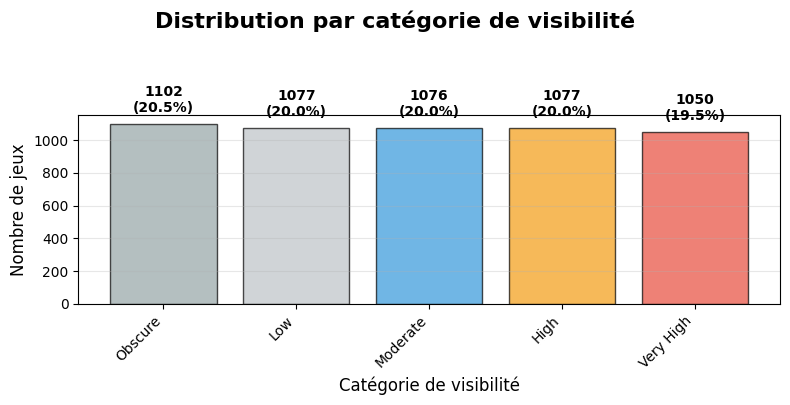

In [620]:
analyze_visibility_score(df_visibility_score)

In [621]:
# merge colonne visibility cat
df_featured = pd.concat([df_featured, df_visibility_score[['visibility_score','visibility_category']]], axis=1)

## Combiner esrb et pegi

In [622]:
df_pegi_unified = df_featured.copy()

In [623]:
print(df_pegi_unified['esrb_rating'].unique())

['Everyone' nan 'Everyone 10+' 'Teen' 'Mature 17+' 'Adults Only 18+']


In [624]:
print(df_pegi_unified['pegi_rating'].unique())

<IntegerArray>
[7, 3, <NA>, 16, 12, 18]
Length: 6, dtype: Int64


In [625]:
# Combiner les colonnes esrb_rating et pegi_rating en une seule colonne 'esrb_pegi_merged'

# Mapping ESRB → PEGI
esrb_to_pegi = {
    'Everyone': 3,
    'Everyone 10+': 7,
    'Teen': 12,
    'Mature 17+': 16,
    'Adults Only 18+': 18
}

In [626]:
df_pegi_unified['pegi_unified'] = df_pegi_unified['pegi_rating'].fillna(df_pegi_unified['esrb_rating'].map(esrb_to_pegi))

In [627]:
print("Distribution pegi:")
print("=" * 60)

total_assignments = df_pegi_unified['pegi_unified']

for esrb_index,pegi_index in esrb_to_pegi.items():
    count = (total_assignments == pegi_index).sum()
    pct = count / len(df_pegi_unified) * 100
    print(f"   {pegi_index}: {count:5d} jeux ({pct:5.1f}%)")

nan_count = df_pegi_unified['pegi_unified'].isna().sum()
nan_pct = (nan_count / len(df)) * 100
print(f"NaN: {nan_count} ({nan_pct:.2f}%)")

Distribution pegi:
   3:  2015 jeux ( 37.4%)
   7:  1064 jeux ( 19.8%)
   12:  1062 jeux ( 19.7%)
   16:   924 jeux ( 17.2%)
   18:   317 jeux (  5.9%)
NaN: 0 (0.00%)


In [628]:
def analyze_pegi_unified(df:pd.DataFrame, pegi_column='pegi_unified'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1:plt.Axes
    ax2:plt.Axes
    
    # Ordre logique
    pegi_order = [3, 7, 12, 16, 18]
    
    # 1. Barplot
    pegi_counts = df[pegi_column].value_counts()
    pegi_counts = pegi_counts.reindex(pegi_order, fill_value=0)
    
    # Couleurs (gradient du vert au rouge)
    colors = ['#4caf50', '#8bc34a', '#ffc107', '#ff9800', '#f44336']
    
    bars = ax1.bar([f'PEGI {p}' for p in pegi_order], pegi_counts.values, 
                   color=colors, alpha=0.7, edgecolor='black')
    
    ax1.set_ylabel('Nombre de jeux', fontsize=12)
    ax1.set_xlabel('Classification PEGI', fontsize=12)
    ax1.set_title('Distribution PEGI unifiée', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Ajouter valeurs et pourcentages
    total = pegi_counts.sum()
    for bar, count in zip(bars, pegi_counts.values):
        pct = count / total * 100
        ax1.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    # 2. Pie chart
    wedges, texts, autotexts = ax2.pie(pegi_counts.values, 
                                        labels=[f'PEGI {p}' for p in pegi_order],
                                        colors=colors, autopct='%1.1f%%',
                                        startangle=90, textprops={'fontsize': 11})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('Répartition PEGI unifiée', fontsize=14, fontweight='bold')
    
    plt.suptitle('Analyse de la classification PEGI unifiée', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

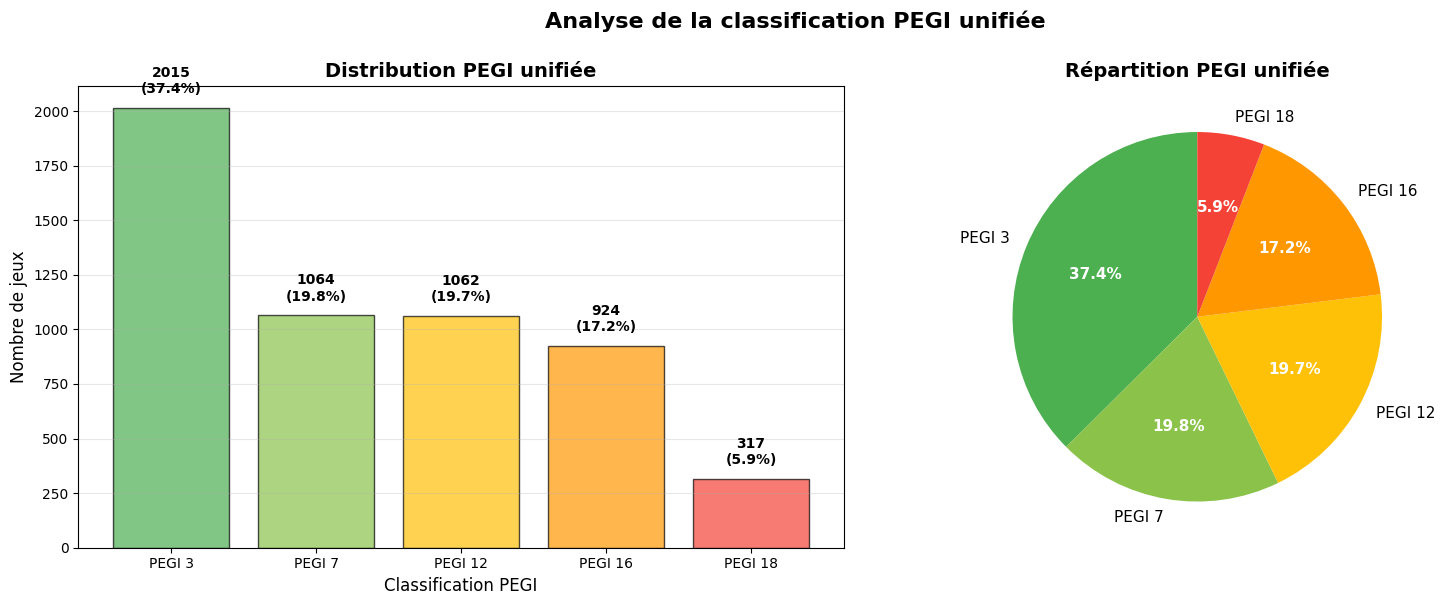

In [629]:
# Utilisation
analyze_pegi_unified(df_pegi_unified)

In [630]:
df_featured = pd.concat([df_featured, df_pegi_unified[['pegi_unified']]], axis=1)

## Classification des prix pour distribution train / test

In [631]:
def add_price_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Ajoute une colonne 'price_category' basée sur des segments de prix
    """
    df_result = df.copy()
     
    # Fonction pour catégoriser un prix
    def categorize_price(price):
        if pd.isna(price):
            return None
        
        for segment in PRICE_SEGMENTS:
            if segment["value_min"] <= price <= segment["value_max"]:
                return segment["label"]
        
        # Si prix > 150, mettre dans "40+"
        if price > 150:
            return "40+"
        
        return None
    
    # Appliquer la catégorisation
    df_result['price_category'] = df_result['base_price'].apply(categorize_price)
    
    return df_result

In [632]:
df_featured = add_price_category(df_featured)

# Stats
print("Distribution des catégories de prix:")
print("="*60)

category_counts = df_featured['price_category'].value_counts().sort_index()

# Afficher dans l'ordre des segments
for segment in PRICE_SEGMENTS:
    label = segment["label"]
    if label in category_counts.index:
        count = category_counts[label]
        pct = count / len(df_featured) * 100
        avg_price = df_featured[df_featured['price_category'] == label]['base_price'].mean()
        print(f"   {label:15s}: {count:4d} jeux ({pct:5.1f}%) | Prix moyen: {avg_price:.2f}€")

Distribution des catégories de prix:
   0 - 7.99       : 1723 jeux ( 32.0%) | Prix moyen: 4.51€
   8 - 14.99      : 1297 jeux ( 24.1%) | Prix moyen: 12.03€
   15 - 24.99     : 1206 jeux ( 22.4%) | Prix moyen: 21.07€
   25 - 39.99     :  725 jeux ( 13.5%) | Prix moyen: 33.82€
   40+            :  431 jeux (  8.0%) | Prix moyen: 61.28€


In [633]:
def analyze_price_category(df:pd.DataFrame, price_column='price_category'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1:plt.Axes
    ax2:plt.Axes
    
    # Ordre logique
    category_order = ['0 - 7.99', '8 - 14.99', '15 - 24.99', '25 - 39.99', '40+']
    
    # 1. Barplot
    price_counts = df[price_column].value_counts()
    price_counts = price_counts.reindex(category_order, fill_value=0)
    
    # Couleurs (gradient)
    colors = ['#2ecc71', '#3498db', '#f39c12', '#e67e22', '#e74c3c']
    
    bars = ax1.bar(range(len(category_order)), price_counts.values, 
                   color=colors, alpha=0.7, edgecolor='black')
    
    ax1.set_xticks(range(len(category_order)))
    ax1.set_xticklabels(category_order, rotation=45, ha='right', fontsize=11)
    ax1.set_ylabel('Nombre de jeux', fontsize=12)
    ax1.set_xlabel('Catégorie de prix (€)', fontsize=12)
    ax1.set_title('Distribution des catégories de prix\n', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Ajouter valeurs et pourcentages
    total = price_counts.sum()
    for bar, count in zip(bars, price_counts.values):
        pct = count / total * 100
        ax1.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=10, fontweight='bold')
    
    # 2. Pie chart
    wedges, texts, autotexts = ax2.pie(price_counts.values, 
                                        labels=category_order,
                                        colors=colors, autopct='%1.1f%%',
                                        startangle=90, textprops={'fontsize': 10})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('Répartition des catégories de prix\n', fontsize=14, fontweight='bold')
    
    plt.suptitle('Analyse des catégories de prix', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

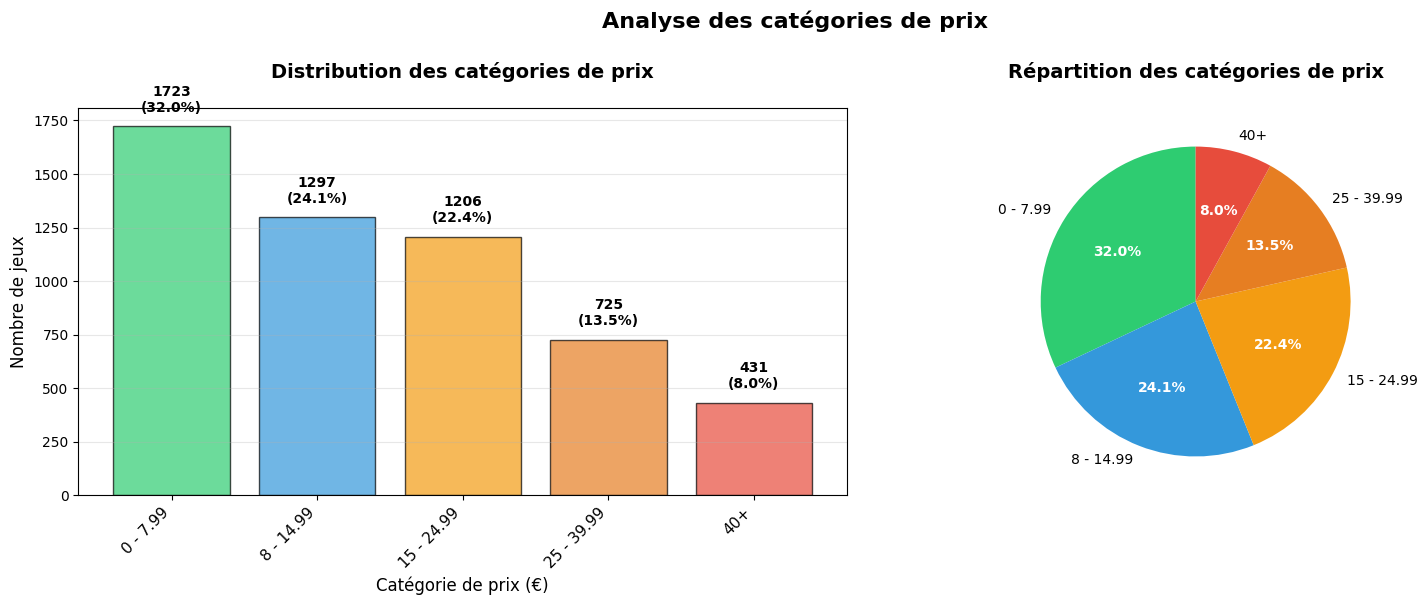

In [634]:
analyze_price_category(df_featured)

## Dates pour modèles

In [635]:
current_year = 2025
df_featured['game_age_years'] = current_year - df_featured['release_year']

In [636]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:  # 9, 10, 11
        return 'fall'
    
df_featured['release_season'] = df_featured['release_month'].apply(get_season)

In [637]:
def analyze_release_season(df:pd.DataFrame, season_column='release_season'):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1:plt.Axes
    ax2:plt.Axes
    
    # Ordre logique des saisons
    season_order = ['winter', 'spring', 'summer', 'fall']
    season_labels = ['Hiver\n(Dec-Jan-Fev)', 'Printemps\n(Mar-Avr-Mai)', 
                     'Été\n(Jun-Jul-Aou)', 'Automne\n(Sep-Oct-Nov)']
    
    # Couleurs thématiques
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e67e22']
    
    # 1. Barplot
    season_counts = df[season_column].value_counts()
    season_counts = season_counts.reindex(season_order, fill_value=0)
    
    bars = ax1.bar(season_labels, season_counts.values, 
                   color=colors, alpha=0.7, edgecolor='black')
    
    ax1.set_ylabel('Nombre de jeux', fontsize=12)
    ax1.set_xlabel('Saison de sortie', fontsize=12)
    ax1.set_title('Distribution des sorties par saison\n', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Ajouter valeurs et pourcentages
    total = season_counts.sum()
    for bar, count in zip(bars, season_counts.values):
        pct = count / total * 100
        ax1.text(bar.get_x() + bar.get_width()/2, count + total*0.01,
                f'{count}\n({pct:.1f}%)', ha='center', va='bottom', 
                fontsize=11, fontweight='bold')
    
    # 2. Pie chart
    wedges, texts, autotexts = ax2.pie(season_counts.values, 
                                        labels=season_labels,
                                        colors=colors, autopct='%1.1f%%',
                                        startangle=90, textprops={'fontsize': 11})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    
    ax2.set_title('Répartition des sorties par saison\n', fontsize=14, fontweight='bold')
    
    plt.suptitle('Analyse des saisons de sortie', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()

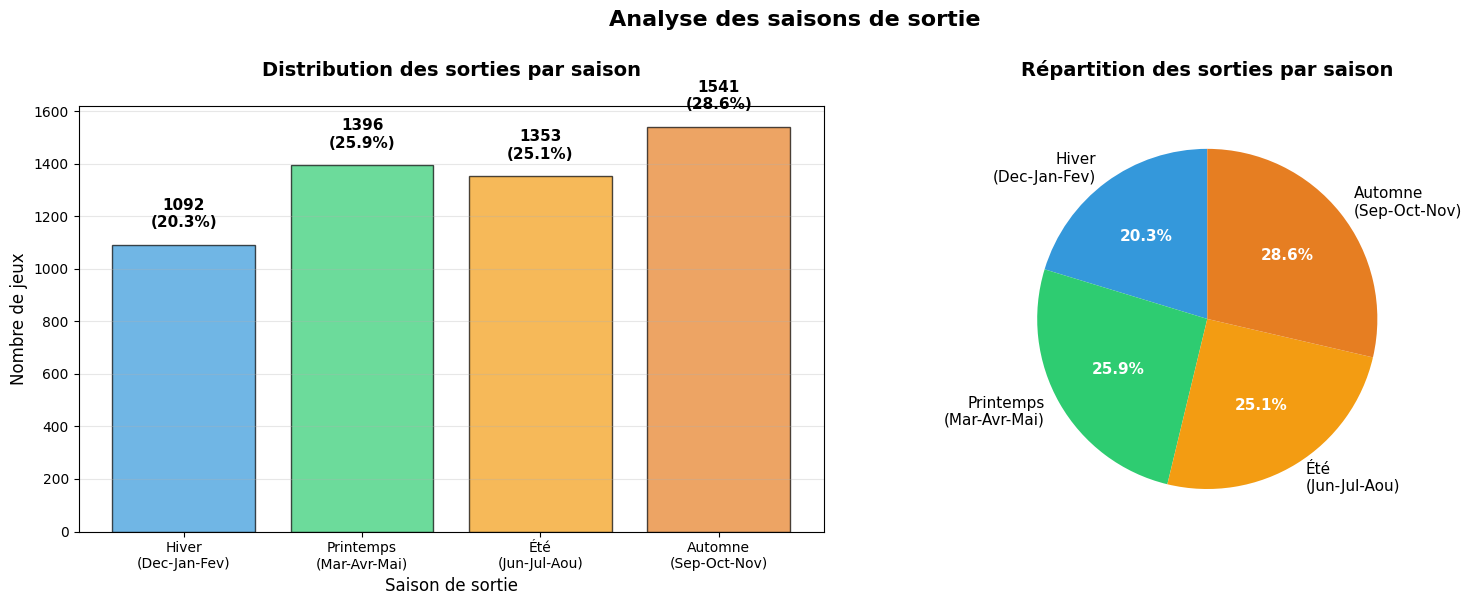

In [638]:
analyze_release_season(df_featured)

## Synthèse des features

In [639]:
# 47 features au total

# X Basic features simple sans traitement avancés (28)

# release_month                 - numeric (int)
# base_price                    - numeric (float)
# pssstore_stars_rating_count   - numeric (int)
# pssstore_stars_rating         - numeric (float)
# is_indie                      - boolean
# has_microtransaction          - boolean
# dlc_count                     - numeric (int)
# packs_deluxe_count            - numeric (int)
# serie_count                   - numeric (int)
# trophies_count                - numeric (int)
# is_vr                         - boolean
# has_local_multiplayer         - boolean
# has_online_multiplayer        - boolean
# is_online_only                - boolean
# is_opti_ps5_pro               - boolean
# is_ps_exclusive               - boolean
# difficulty                    - numeric (int)
# is_remaster                   - boolean
# is_ps4                        - boolean
# pegi_unified                  - category (numeric)
# metacritic_critic_score       - numeric (float)
# hours_main_story              - numeric (float)
# voices_languages_count        - numeric (int)
# sub_languages_count           - numeric (int)
# download_size_gb              - numeric (float)
# price_category                - category



#  X Advanced features engineered (19)

# popularity_score              - numeric (float)
# popularity_category           - category
# visibility_score              - numeric (float)
# visibility_category           - category
# exclusif_playstation_content  - boolean
# publisher_game_count          - numeric (int)
# publisher_game_count_cat      - category
# publisher_category            - category
# genre_action_aventure         - boolean
# genre_roles                   - boolean
# genre_sports                  - boolean
# genre_reflexion               - boolean
# genre_rapide                  - boolean
# localization_score            - score (float)
# localization_category         - category
# download_size_category        - category
# content_score                 - numeric (float)
# content_category              - category
# game_age_years                - numeric (int)
# release_season                - category


#  X Bonus observations à + 60 jours (2)

# has_5pct_discount_at_30d      - boolean
# has_10pct_discount_at_60d     - boolean

# Y
# 
# Regression nombre de jours
# 
# days_to_10_percent_discount - numeric (int)
# days_to_25_percent_discount - numeric (int)
# days_to_33_percent_discount - numeric (int)
# days_to_50_percent_discount - numeric (int)
# days_to_75_percent_discount - numeric (int)

# Classification tranche délais avant promotion
# 
# days_to_10_percent_discount_category - category
# days_to_25_percent_discount_category - category
# days_to_33_percent_discount_category - category
# days_to_50_percent_discount_category - category
# days_to_75_percent_discount_category - category

## Exporter features

In [640]:
column_summary(df_featured)

Résumé détaillé des colonnes:
                                 Column     Type  Non-Null Count  Null Count  Unique Values
                              game_name   object            5382           0           5382
                               id_store   object            5382           0           5382
                         short_url_name   object            5382           0           5382
                              publisher   object            5382           0           1061
                              developer   object            3920        1462           2709
                           release_date   object            5382           0           1347
                  pssstore_stars_rating  float64            5382           0            352
            pssstore_stars_rating_count    int64            5382           0           1583
                metacritic_critic_score    Int64            1268        4114             67
            metacritic_critic_userscore    Int64  

In [641]:
df_featured.head(5)

,game_name,id_store,short_url_name,publisher,developer,release_date,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,metacritic_critic_userscore,...,sub_languages_count,content_score,content_category,exclusif_playstation_content,visibility_score,visibility_category,pegi_unified,price_category,game_age_years,release_season
0,"#Halloween, Super Puzzles Dream",EP8311-PPSA19174_00-0421646910657705,game-halloween-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-10-30,1.57,14,<NA>,<NA>,...,NaN,9.0,minimal,0,7.0,obscure,7,0 - 7.99,2,fall
1,#SinucaAttack,EP2005-PPSA06055_00-SINUCA0000000000,game-sinucaattack-ps5,eastasiasoft,NaN,2022-05-19,3.26,72,<NA>,<NA>,...,NaN,3.0,minimal,0,43.0,moderate,3,0 - 7.99,3,spring
2,"#Wish travel, super puzzle dreams",EP8311-PPSA16513_00-0233078860249892,game-wish-travel-super-puzzle-dreams-ps5,e-llusiontertainment,NaN,2023-05-31,1.55,11,<NA>,<NA>,...,NaN,9.0,minimal,0,7.0,obscure,3,0 - 7.99,2,spring
3,"#WomenUp, Super Puzzles Dream",EP8311-PPSA13840_00-0277389480637871,game-womenup-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2023-01-26,1.44,18,<NA>,<NA>,...,NaN,9.0,minimal,0,8.0,obscure,3,0 - 7.99,2,winter
4,"#Xmas, Super Puzzles Dream",EP8311-PPSA12662_00-0212989199890961,game-xmas-super-puzzles-dream-ps5,e-llusiontertainment,NaN,2022-12-22,1.17,23,<NA>,<NA>,...,NaN,9.0,minimal,0,8.0,obscure,3,0 - 7.99,3,winter


#### Supprimer les colonnes qui ne seront pas utiles

In [642]:
col_to_delete = [
    'price_history',
    'genres',
    'game_name',
    'short_url_name',
    'publisher',
    'developer',
    'pegi_rating',
    'esrb_rating',
    'release_date',
    'voice_languages',
    'subtitle_languages',
    'lowest_price',
    'download_size',
    'metacritic_critic_userscore',
    'days_since_release',
    'rating_descriptions'
]

# Si uniquement ps5 supprimer isPs5, check nombre valeur 0 dans la colonne is_ps5
if int(df_featured['is_ps5'].value_counts().get(0, 0)) == 0: 
    col_to_delete.append('is_ps5')
    
print(col_to_delete)

['price_history', 'genres', 'game_name', 'short_url_name', 'publisher', 'developer', 'pegi_rating', 'esrb_rating', 'release_date', 'voice_languages', 'subtitle_languages', 'lowest_price', 'download_size', 'metacritic_critic_userscore', 'days_since_release', 'rating_descriptions', 'is_ps5']


In [643]:
df_to_export = df_featured.drop(columns=col_to_delete)

In [644]:
column_summary(df_to_export)

Résumé détaillé des colonnes:
                                 Column     Type  Non-Null Count  Null Count  Unique Values
                               id_store   object            5382           0           5382
                  pssstore_stars_rating  float64            5382           0            352
            pssstore_stars_rating_count    int64            5382           0           1583
                metacritic_critic_score    Int64            1268        4114             67
                                 is_ps4    int64            5382           0              2
                               is_indie    int64            5382           0              2
                                 is_dlc    int64            5382           0              1
                                  is_vr    int64            5382           0              2
                        is_opti_ps5_pro    int64            5382           0              2
                            is_remaster    int64  

## Matrice de corrélation avec les nouvelles features

- spearman: Mesure les relations monotones (pas forcément linéaires)
- pearson: Mesure les relations linéaires

In [645]:
df_for_afc = df_to_export.copy()

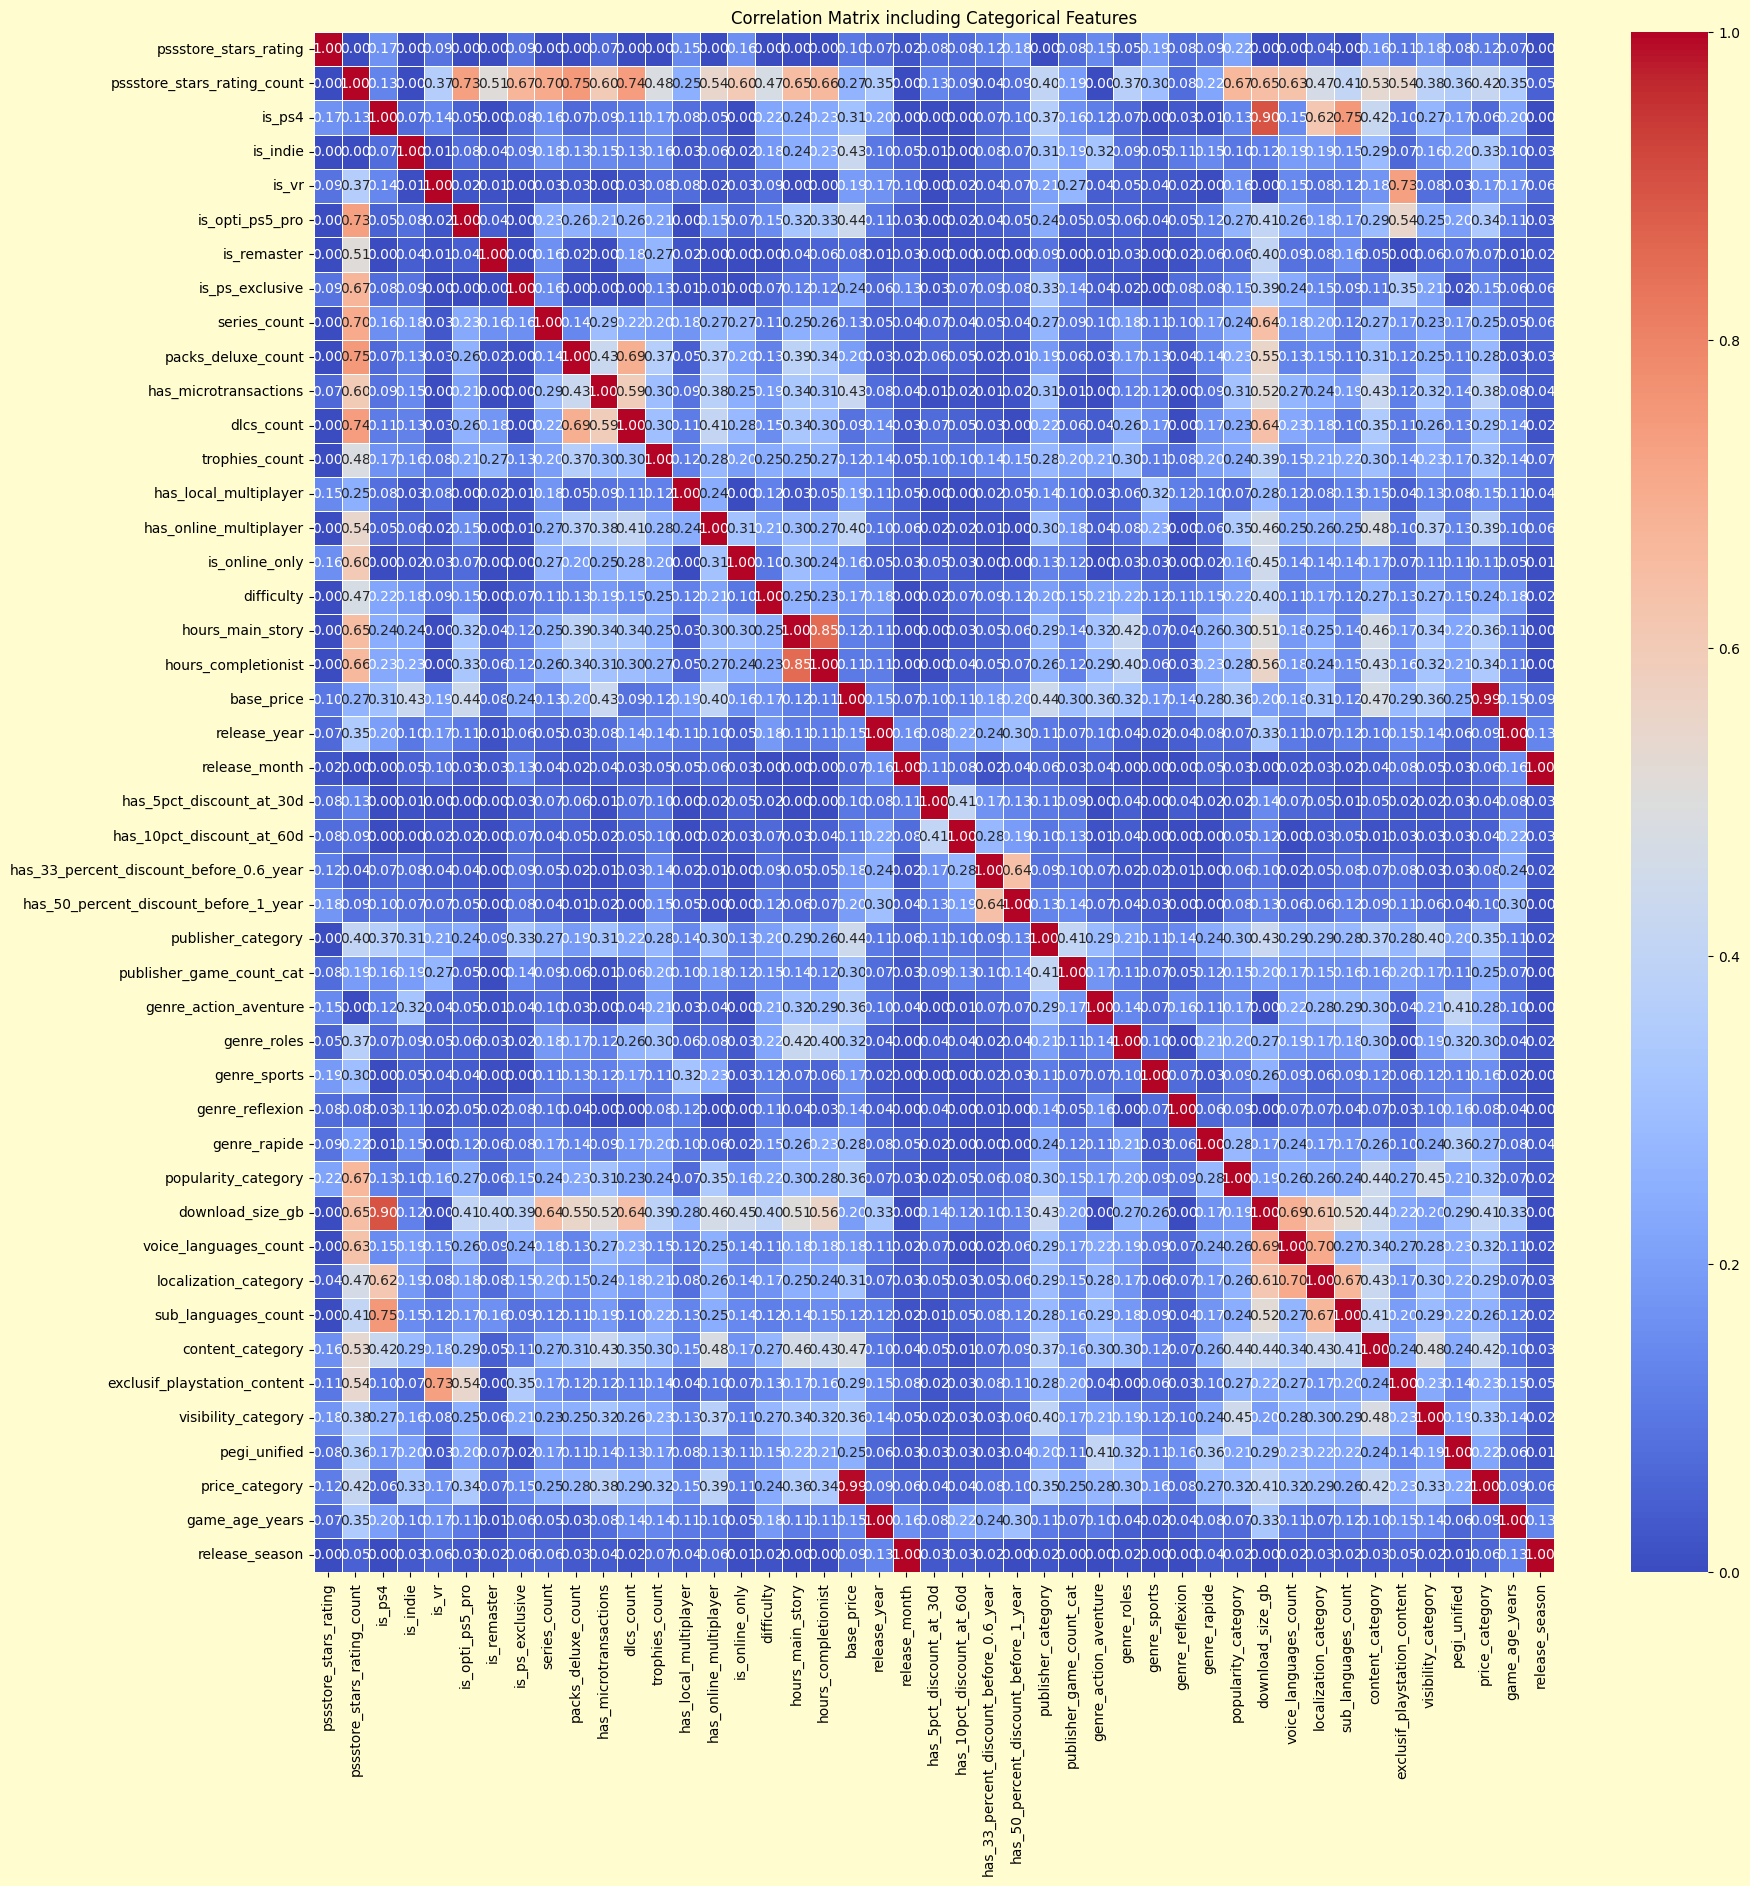

In [646]:
from dython.nominal import associations

feature_columns_to_drop = [
    'is_dlc',
    'game_name',
    'id_store',
    'short_url_name',
    'rating_descriptions',
    'price_history',
    'is_ps5',
    'visibility_score',
    # 'pssstore_stars_rating_count',
    'metacritic_critic_score',
    'content_score',
    'days_to_10_percent_discount',
    'days_to_25_percent_discount',
    'days_to_33_percent_discount',
    'days_to_50_percent_discount',
    'days_to_75_percent_discount',
    'days_to_10_percent_discount_category',
    'days_to_25_percent_discount_category',
    'days_to_33_percent_discount_category',
    'days_to_50_percent_discount_category',
    'days_to_75_percent_discount_category',
    'has_75_percent_discount_before_3_year',
    'popularity_score',
    'publisher_game_count',
    'online_multiplayer_max_players',
    'local_multiplayer_max_players',
    'download_size_category'
    
]

df_for_afc_2 = df_for_afc.drop(columns=feature_columns_to_drop,errors='ignore')

associations_df = associations(df_for_afc_2, nominal_columns='all',num_num_assoc='pearson', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 20))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()

### Affichage des corrélations avec les prédictions attendues

In [647]:
def print_correlations_spearman_simple(df:pd.DataFrame, target_column='pssstore_stars_rating_count'):

    # Sélectionner uniquement les colonnes numériques
    numeric_df = df.select_dtypes(include=[np.number])
    
    if target_column not in numeric_df.columns:
        print(f"Erreur: '{target_column}' n'est pas numérique")
        return
    
    correlations = numeric_df.corr('spearman')[target_column].sort_values(ascending=False)
    correlations = correlations.drop(target_column)
    
    print(f"\nCorrélations avec {target_column}:")
    
    for col, corr in correlations.items():
        print(f"{col:50s} {corr:>8.3f}")
    

In [648]:
def analyze_correlations_with_popularity_complete(df:pd.DataFrame,num_num_assoc="spearman", target_column='pssstore_stars_rating_count'):
    print("\n" + "="*80)
    print(f"CORRÉLATIONS AVEC '{target_column}' (POPULARITÉ)")
    print("Inclut variables numériques ET catégorielles")
    print("="*80)
    
    # Calculer la matrice d'associations (gère num et cat)
    assoc_matrix = associations(
        df, 
        nom_nom_assoc='cramer',  # Cramer's V pour cat-cat
        num_num_assoc=num_num_assoc,  # Pearson pour num-num
        nan_strategy='drop_samples',
        plot=False  # Pas de plot automatique
    )
    
    # Extraire les corrélations avec la colonne cible
    if target_column in assoc_matrix['corr'].columns:
        correlations = assoc_matrix['corr'][target_column].sort_values(ascending=False)
        correlations = correlations.drop(target_column)  # Retirer elle-même
        
        print(f"\n{'Colonne':<50} {'Corrélation':>15} {'Type':>10}")
        print("-" * 85)
        
        for col, corr in correlations.items():
            if abs(corr) > 0.01:
                # Déterminer le type
                if df[col].dtype in ['object', 'category']:
                    col_type = "CAT"
                else:
                    col_type = "NUM"
                
                # Symbole visuel
                if corr > 0.3:
                    symbol = "+++"
                elif corr > 0.1:
                    symbol = "++"
                elif corr > 0:
                    symbol = "+"
                elif corr > -0.1:
                    symbol = "-"
                elif corr > -0.3:
                    symbol = "--"
                else:
                    symbol = "---"
                
                print(f"{col:<50} {corr:>10.3f}   {col_type:>8}  {symbol}")
        
        print("\n" + "-" * 85)
        print("Légende: +++ forte | ++ moyenne | + faible")
        print("Type: NUM = numérique | CAT = catégorielle")
        print("="*80 + "\n")
        
    else:
        print(f"Erreur: '{target_column}' introuvable dans la matrice de corrélations")

### Corrélation prédiction popularité

In [649]:
analyze_correlations_with_popularity_complete(df_for_afc_2,num_num_assoc='spearman', target_column='pssstore_stars_rating_count')


CORRÉLATIONS AVEC 'pssstore_stars_rating_count' (POPULARITÉ)
Inclut variables numériques ET catégorielles

Colonne                                                Corrélation       Type
-------------------------------------------------------------------------------------
download_size_gb                                        0.703        NUM  +++
hours_main_story                                        0.609        NUM  +++
base_price                                              0.581        NUM  +++
hours_completionist                                     0.578        NUM  +++
dlcs_count                                              0.565        NUM  +++
trophies_count                                          0.561        NUM  +++
series_count                                            0.489        NUM  +++
packs_deluxe_count                                      0.473        NUM  +++
has_microtransactions                                   0.421        NUM  +++
has_online_multiplayer    

In [650]:
analyze_correlations_with_popularity_complete(df_for_afc_2,num_num_assoc='pearson', target_column='pssstore_stars_rating_count')


CORRÉLATIONS AVEC 'pssstore_stars_rating_count' (POPULARITÉ)
Inclut variables numériques ET catégorielles

Colonne                                                Corrélation       Type
-------------------------------------------------------------------------------------
download_size_gb                                        0.456        NUM  +++
publisher_category                                      0.280        CAT  ++
has_microtransactions                                   0.278        NUM  ++
series_count                                            0.269        NUM  ++
difficulty                                              0.253        NUM  ++
base_price                                              0.238        NUM  ++
content_category                                        0.231        CAT  ++
price_category                                          0.219        CAT  ++
trophies_count                                          0.210        NUM  ++
popularity_category               

In [651]:
df_for_afc_2['log_pssstore_stars_rating_count'] = np.log1p(df_for_afc_2['pssstore_stars_rating_count'])
analyze_correlations_with_popularity_complete(df_for_afc_2,num_num_assoc='spearman', target_column='log_pssstore_stars_rating_count')


CORRÉLATIONS AVEC 'log_pssstore_stars_rating_count' (POPULARITÉ)
Inclut variables numériques ET catégorielles

Colonne                                                Corrélation       Type
-------------------------------------------------------------------------------------
pssstore_stars_rating_count                             1.000        NUM  +++
popularity_category                                     0.885        CAT  +++
content_category                                        0.790        CAT  +++
visibility_category                                     0.728        CAT  +++
download_size_gb                                        0.703        NUM  +++
hours_main_story                                        0.609        NUM  +++
publisher_category                                      0.606        CAT  +++
base_price                                              0.581        NUM  +++
hours_completionist                                     0.578        NUM  +++
price_category        

### Corrélation avec prédiction délais avant baisse de prix

In [652]:
analyze_correlations_with_popularity_complete(df_for_afc_2,num_num_assoc='spearman', target_column='has_50_percent_discount_before_1_year')


CORRÉLATIONS AVEC 'has_50_percent_discount_before_1_year' (POPULARITÉ)
Inclut variables numériques ET catégorielles

Colonne                                                Corrélation       Type
-------------------------------------------------------------------------------------
has_33_percent_discount_before_0.6_year                 0.620        NUM  +++
has_10pct_discount_at_60d                               0.285        NUM  ++
price_category                                          0.204        CAT  ++
has_5pct_discount_at_30d                                0.181        NUM  ++
publisher_game_count_cat                                0.154        CAT  ++
popularity_category                                     0.148        CAT  ++
has_local_multiplayer                                   0.124        NUM  ++
base_price                                              0.116        NUM  ++
voice_languages_count                                   0.110        NUM  ++
content_category        

In [653]:
analyze_correlations_with_popularity_complete(df_for_afc_2,num_num_assoc='pearson', target_column='has_50_percent_discount_before_1_year')


CORRÉLATIONS AVEC 'has_50_percent_discount_before_1_year' (POPULARITÉ)
Inclut variables numériques ET catégorielles

Colonne                                                Corrélation       Type
-------------------------------------------------------------------------------------
has_33_percent_discount_before_0.6_year                 0.620        NUM  +++
has_10pct_discount_at_60d                               0.285        NUM  ++
price_category                                          0.204        CAT  ++
has_5pct_discount_at_30d                                0.181        NUM  ++
publisher_game_count_cat                                0.154        CAT  ++
popularity_category                                     0.148        CAT  ++
base_price                                              0.143        NUM  ++
has_local_multiplayer                                   0.124        NUM  ++
voice_languages_count                                   0.107        NUM  ++
content_category        

## Export pour la partie entrainement des modèles ML

In [654]:
df_to_export['log_pssstore_stars_rating_count'] = np.log1p(df_featured['pssstore_stars_rating_count'])

In [655]:
path_export = os.path.join(Path.cwd().parent, "data/processed/featured_games_dataset_final.csv")

df_to_export.to_csv(path_export, index=False, encoding="utf-8")

In [656]:
# Charger les données CSV pour verifier
df_exported = pd.read_csv(path_export)

In [657]:
column_summary(df_exported)

Résumé détaillé des colonnes:
                                 Column    Type  Non-Null Count  Null Count  Unique Values
                               id_store  object            5382           0           5382
                  pssstore_stars_rating float64            5382           0            352
            pssstore_stars_rating_count   int64            5382           0           1583
                metacritic_critic_score float64            1268        4114             67
                                 is_ps4   int64            5382           0              2
                               is_indie   int64            5382           0              2
                                 is_dlc   int64            5382           0              1
                                  is_vr   int64            5382           0              2
                        is_opti_ps5_pro   int64            5382           0              2
                            is_remaster   int64            5